**Overall Oil production prediction**

**-Exponential Smoothing**

**-SARIMA Model**

**-SARIMAX Model**

**- VAR Model**

In [1]:
from sqlalchemy import create_engine, MetaData, or_, and_
from sqlalchemy import select, func 
from db_schema import OIL_PROD_TABLE, GAS_PROD_TABLE, LEASE_TABLE, WELLS_TABLE, TOPS_TABLE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima.arima import auto_arima
from pmdarima import model_selection
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [2]:
class CFG:
    img_dim1 = 16
    img_dim2 = 12
    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})

In [3]:
engine = create_engine("sqlite:///../data/kansas_oil_gas.db")
# Reflect oil production table
meta = MetaData()
meta.reflect(bind=engine)
oil_prod = meta.tables[OIL_PROD_TABLE]
gas_prod = meta.tables[GAS_PROD_TABLE]
lease = meta.tables[LEASE_TABLE]
wells = meta.tables[WELLS_TABLE]
tops = meta.tables[TOPS_TABLE]

In [4]:
s = select(
    [
        oil_prod.c.DATE,
        func.sum(oil_prod.c.WELLS).label("N_WELLS"),
        func.sum(oil_prod.c.PRODUCTION).label("MONTHLY_OIL_PROD"),
    ]
).group_by(oil_prod.c.DATE)
df_oil_prod = pd.read_sql(s, engine)

df_oil_prod.head()

,DATE,N_WELLS,MONTHLY_OIL_PROD
0,1980-01-01,32290,4890470.0
1,1980-02-01,31768,4660825.0
2,1980-03-01,31682,4663943.0
3,1980-04-01,33500,5071219.0
4,1980-05-01,33103,5085228.0


In [5]:
df_oil_prod['DATE'] = pd.to_datetime(df_oil_prod['DATE'])
df_oil_prod.set_index('DATE', inplace = True)
df_oil_prod.head()

,N_WELLS,MONTHLY_OIL_PROD
DATE,,
1980-01-01,32290,4890470.0
1980-02-01,31768,4660825.0
1980-03-01,31682,4663943.0
1980-04-01,33500,5071219.0
1980-05-01,33103,5085228.0


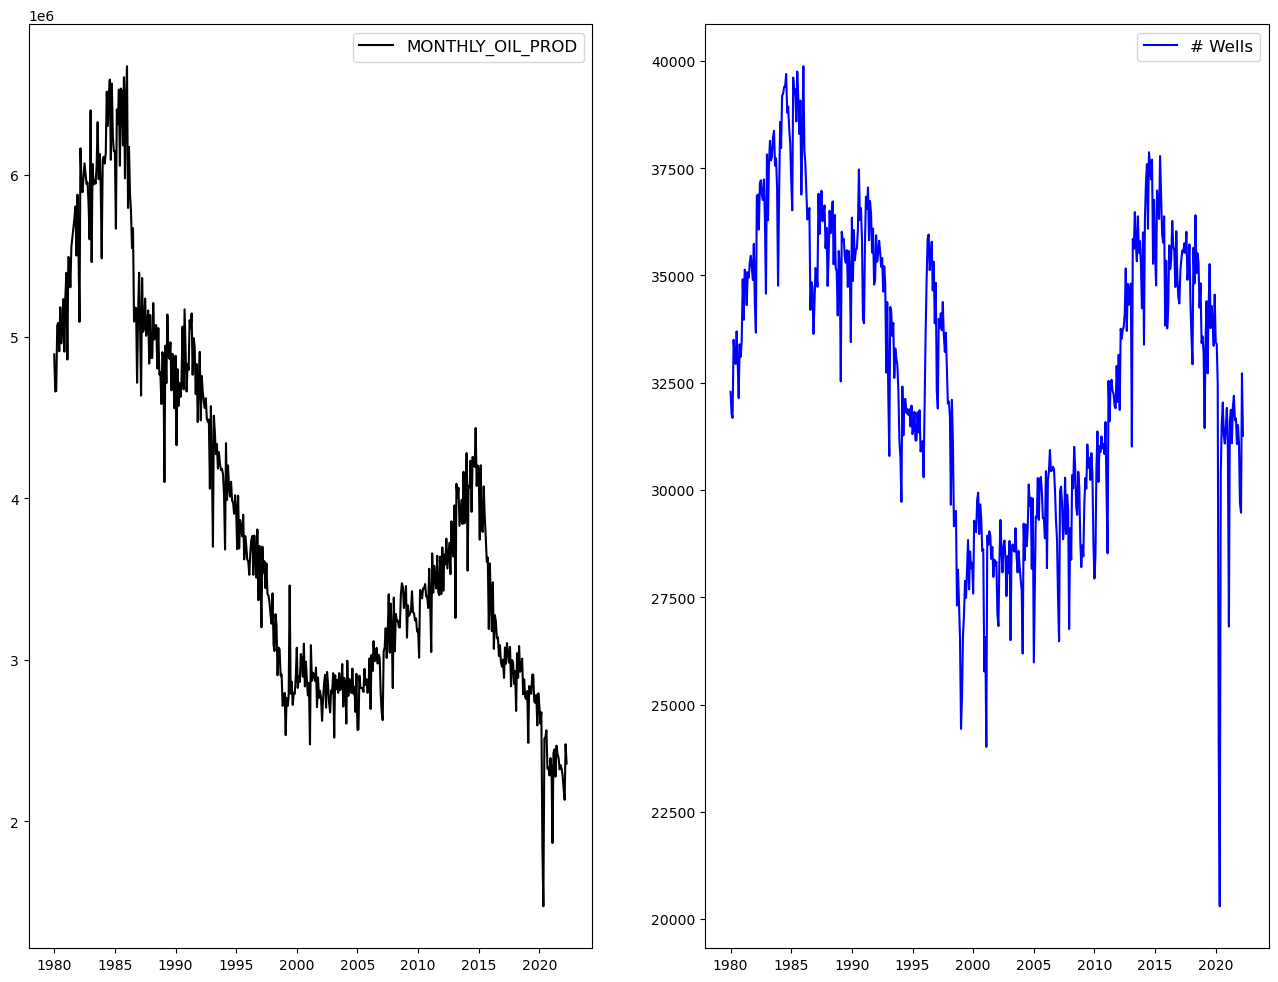

In [6]:
plt.subplot(1, 2, 2)

plt.subplot(1, 2, 1)
plt.plot(df_oil_prod['MONTHLY_OIL_PROD'], color='black', label='MONTHLY_OIL_PROD')
plt.legend(loc='upper right', fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(df_oil_prod['N_WELLS'], color='blue', label='# Wells')
plt.legend(loc='upper right', fontsize=12)
plt.show()

**EDA: Seasonal decomposition**

Decompose the time series into trend, seasonality and the reminder (residual), which is the model can not account for.

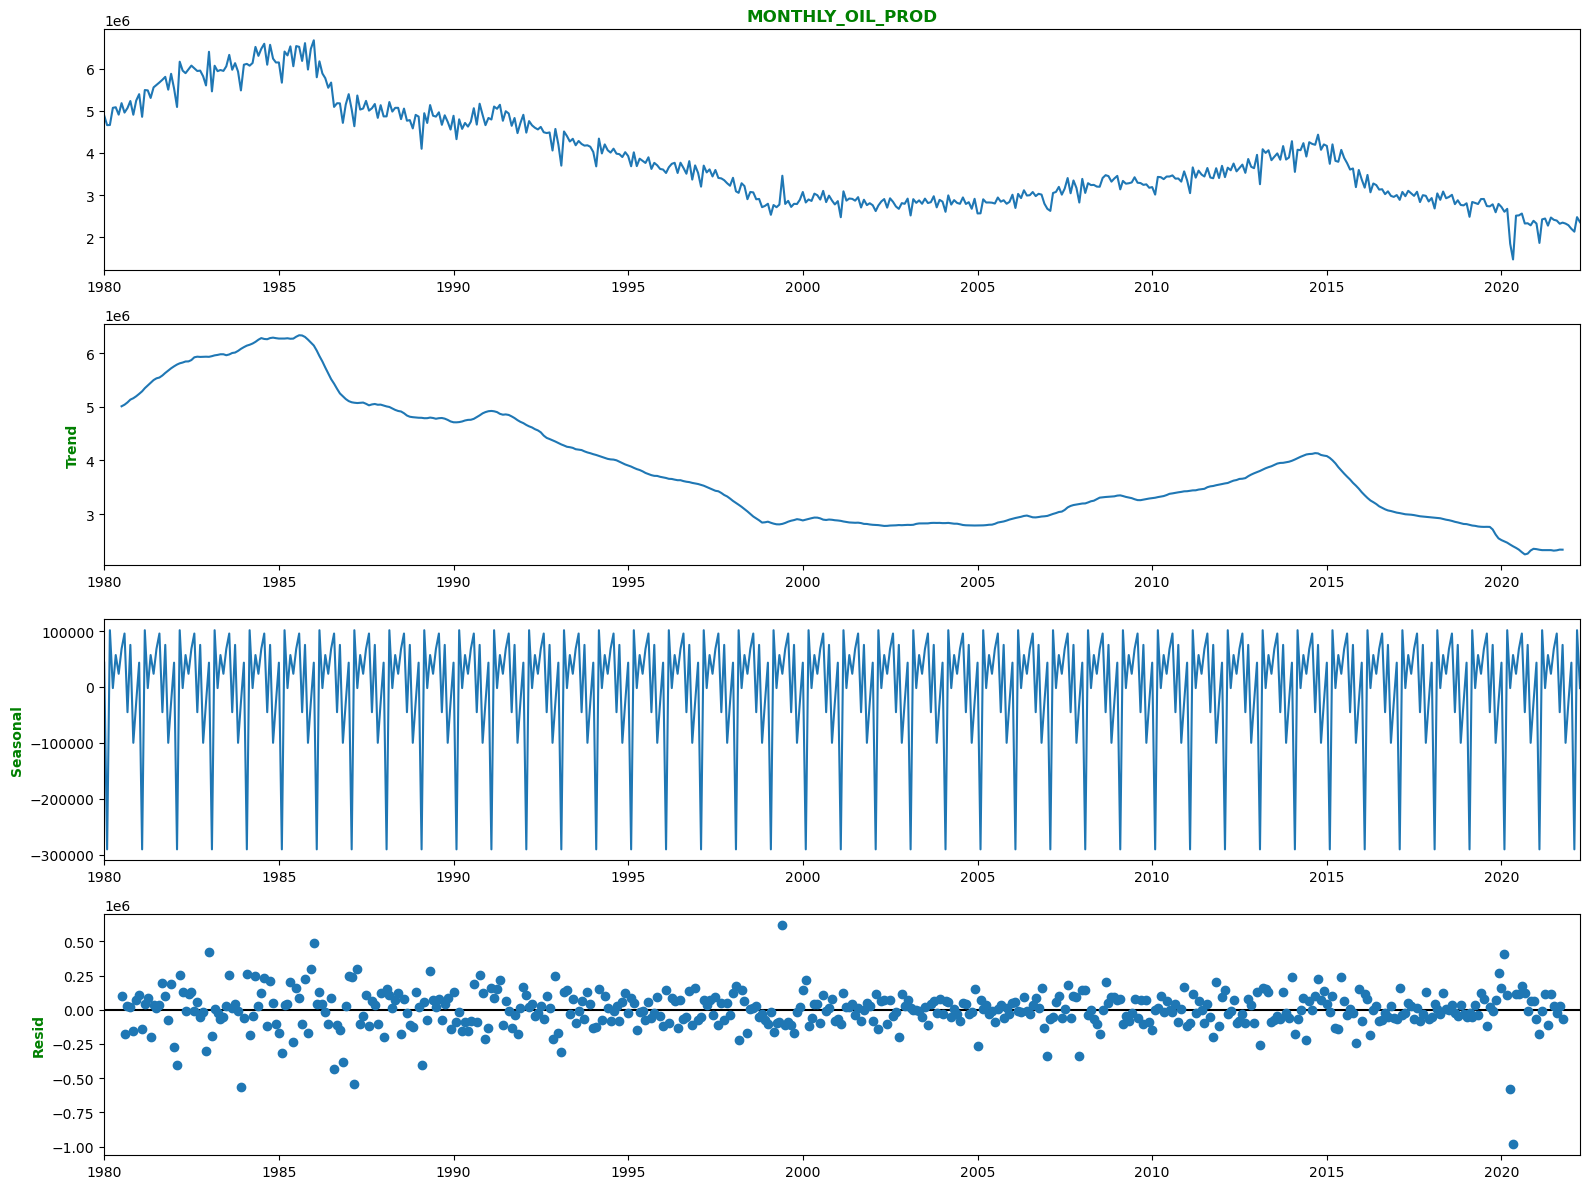

In [52]:
#plt.rcParams.update(plt.rcParamsDefault)
legend_properties = {'weight':'bold'}

decomposition = seasonal_decompose(df_oil_prod['MONTHLY_OIL_PROD'], period = 12)
figure = decomposition.plot()
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['axes.titleweight']='bold'
plt.rcParams['axes.labelcolor'] = "Green"
plt.rcParams['axes.titlecolor'] = "Green"
#plt.rcParams.update({'font.size': 20})
plt.show()

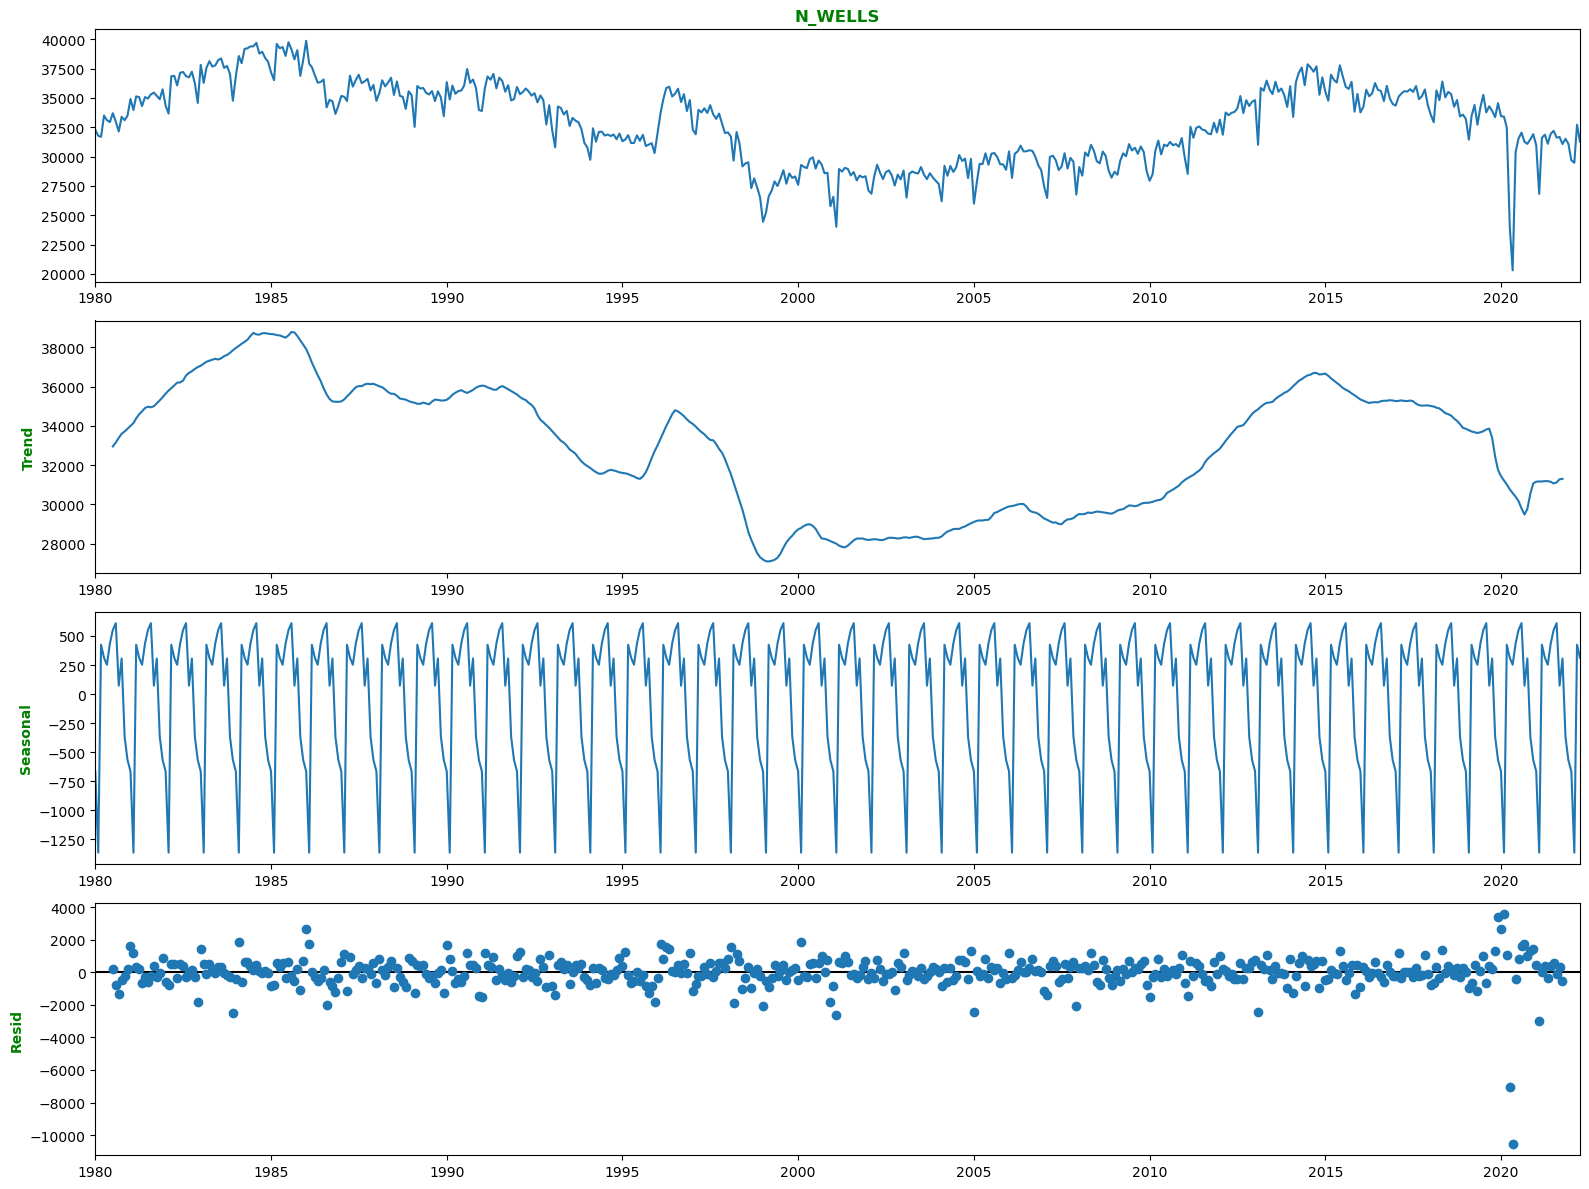

In [8]:
decomposition = seasonal_decompose(df_oil_prod['N_WELLS'], period = 12)
figure = decomposition.plot()
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['axes.titleweight']='bold'
plt.rcParams['axes.labelcolor'] = "Green"
plt.rcParams['axes.titlecolor'] = "Green"
plt.show()

There is a clear trend - Oil production decreases overall

Also, there is clear seasonality.

Residuals - almost symmetrical around zero

Lets try "multiplicative" seasonality.

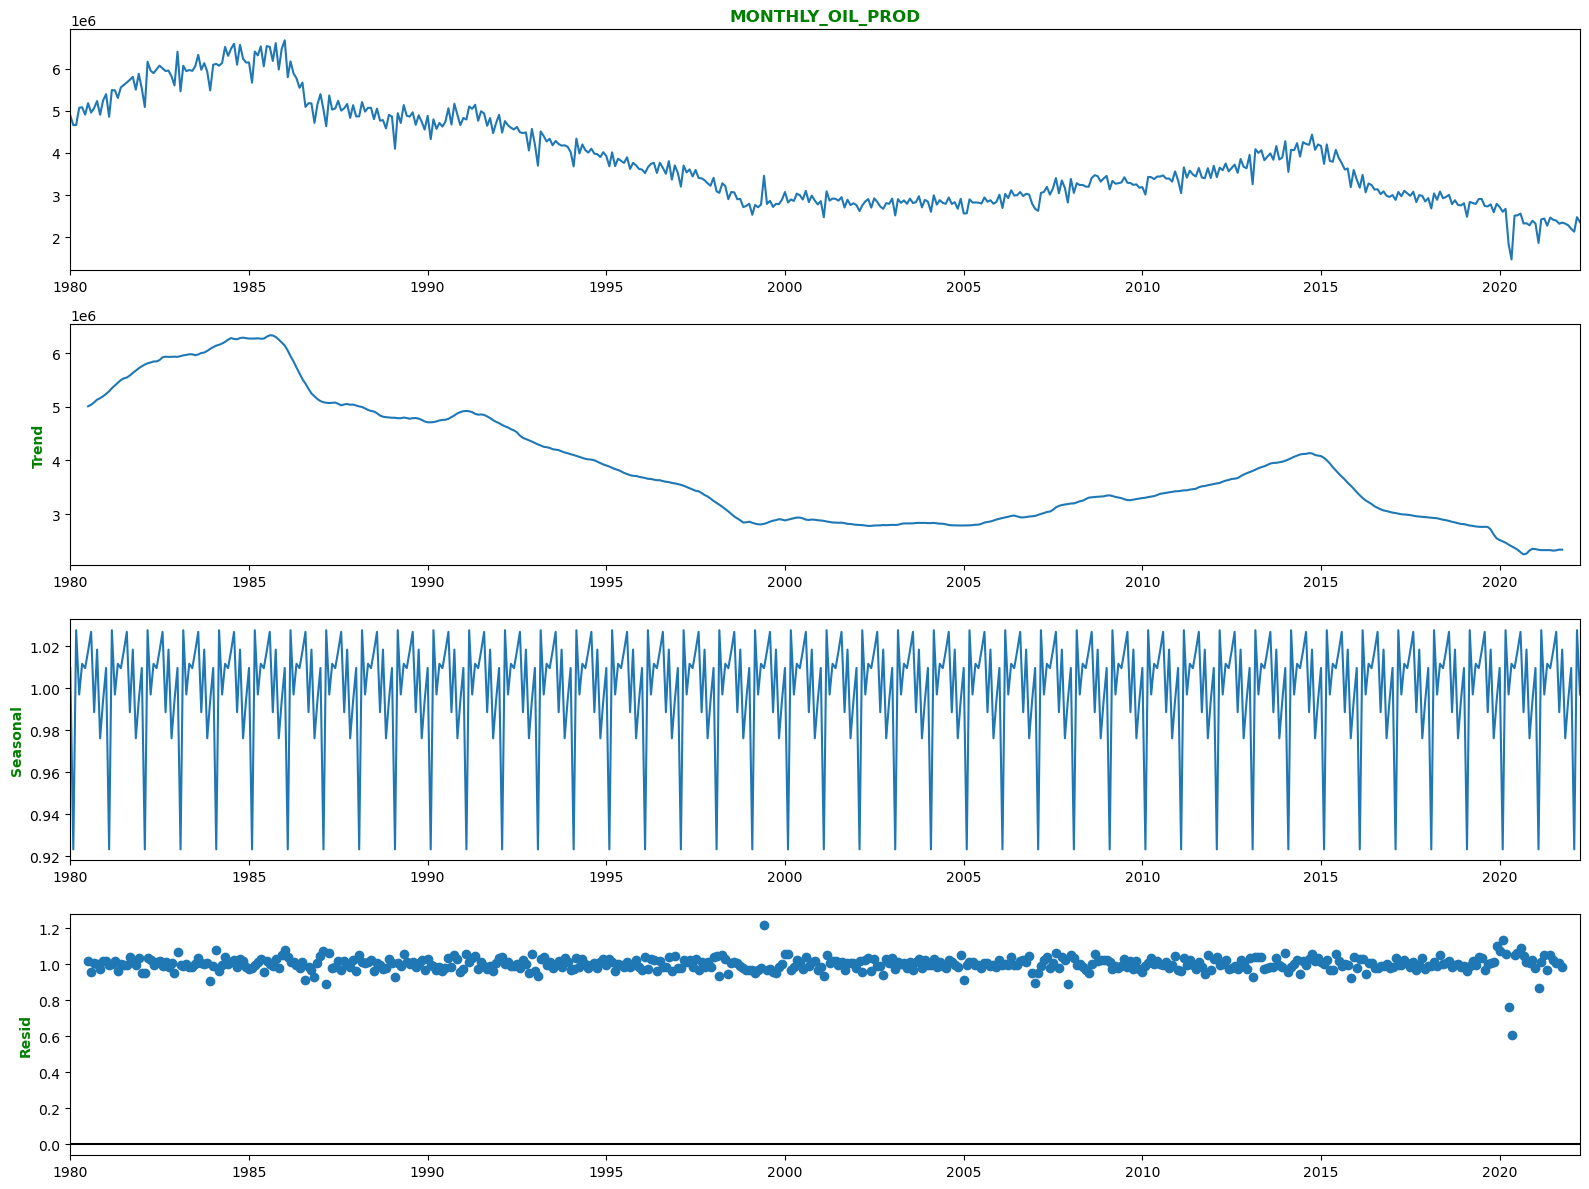

In [9]:

decomposition_mul = seasonal_decompose(df_oil_prod['MONTHLY_OIL_PROD'], period = 12, model = 'multiplicative')
figure = decomposition_mul.plot()
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['axes.titleweight']='bold'
plt.rcParams['axes.labelcolor'] = "Green"
plt.rcParams['axes.titlecolor'] = "Green"
plt.show()

"multiplicative" seasonality did not add much, we stay with "additive" seasonality.

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


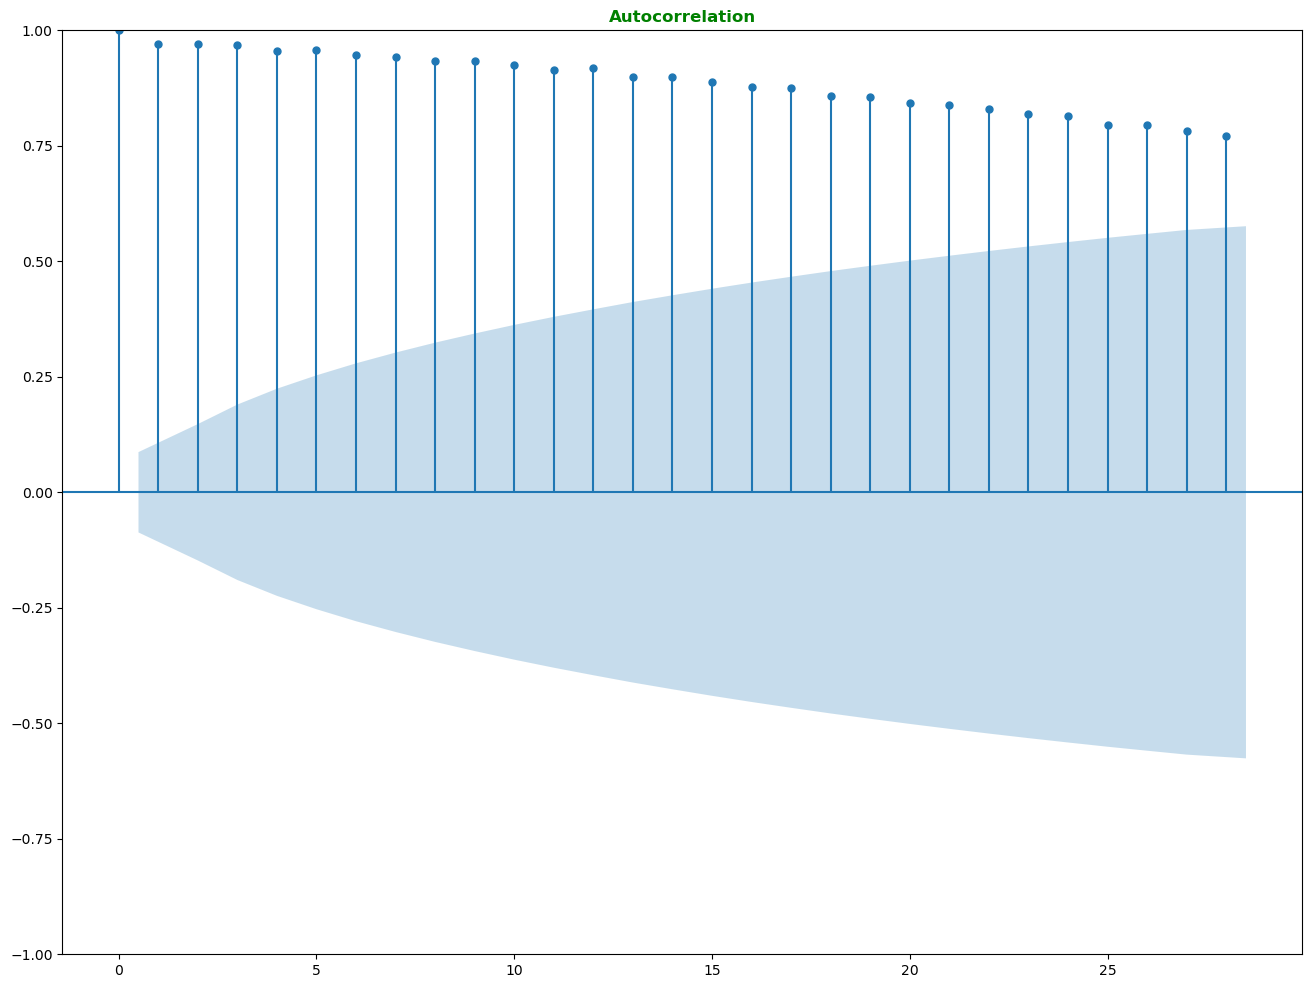

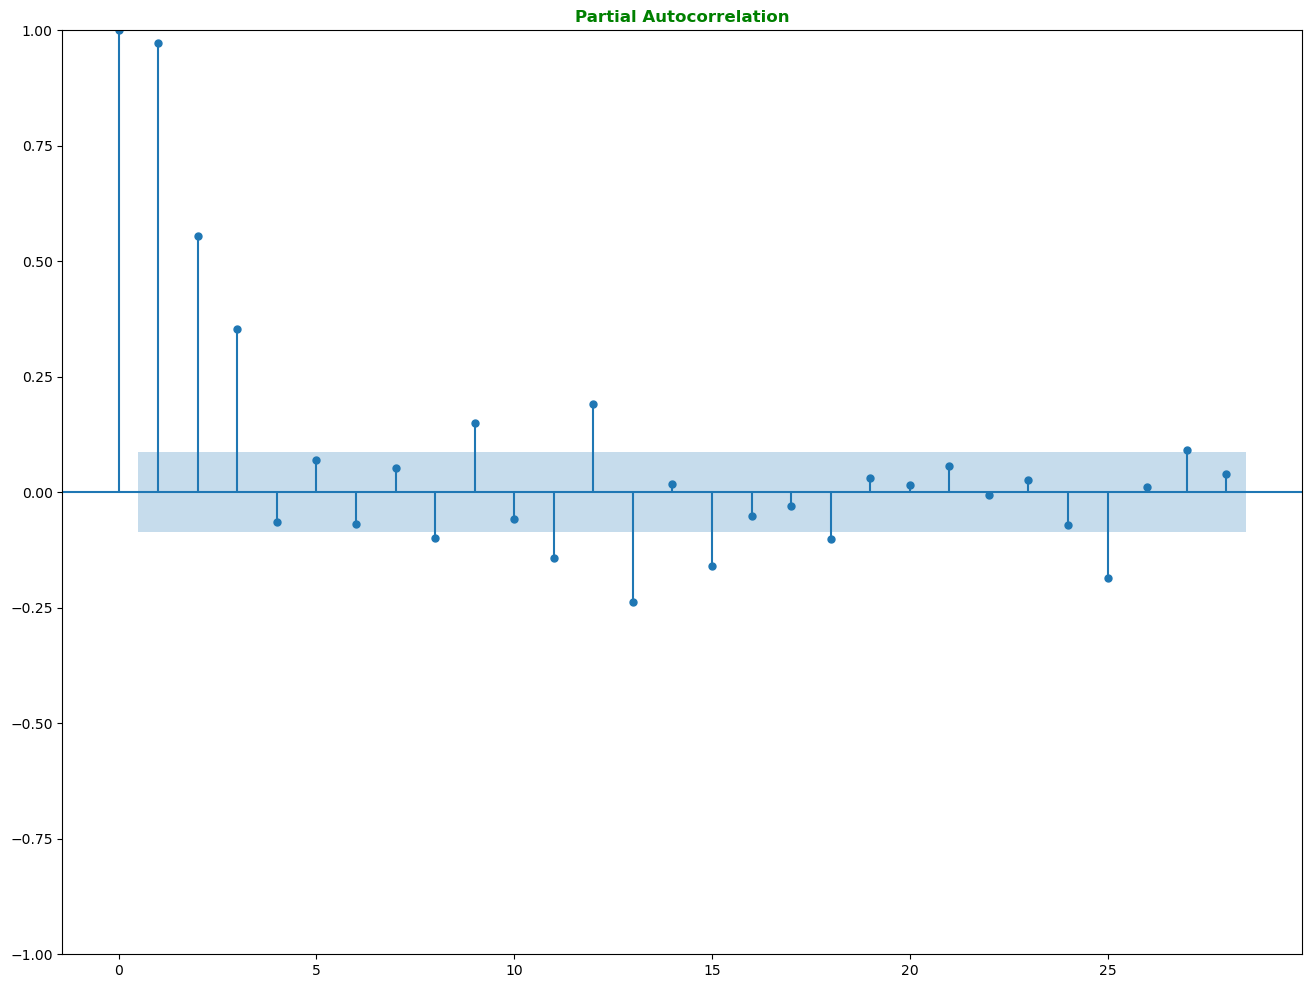

In [10]:
plot_acf(df_oil_prod['MONTHLY_OIL_PROD'])
print()

plot_pacf(df_oil_prod['MONTHLY_OIL_PROD'])
print()

ACF & PACF plots also indicate clear trend and seasonality.

**Stationarity Check - Augmented Dickey-Fuller Test**

In [11]:
# Source - https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

def adfuller_test(series, name='', signif=0.05, verbose=False):
    
    """Perform ADFuller to test for Stationarity of given series and print report"""
    
    r = adfuller(series, autolag='AIC')
    
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n" )
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [12]:
adfuller_test(df_oil_prod['MONTHLY_OIL_PROD'], 'MONTHLY_OIL_PROD')

    Augmented Dickey-Fuller Test on "MONTHLY_OIL_PROD" 

 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.4659
 No. Lags Chosen       = 17
 Critical value 1%     = -3.444
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.5503. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


In [13]:
adfuller_test(df_oil_prod['N_WELLS'], 'N_WELLS')

    Augmented Dickey-Fuller Test on "N_WELLS" 

 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.4896
 No. Lags Chosen       = 12
 Critical value 1%     = -3.444
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.5387. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


Since data is Non-Stationary, take the difference and re-test for Stationary

In [14]:
# 1st difference
df_diff = df_oil_prod.diff().dropna()
df_diff.head()

,N_WELLS,MONTHLY_OIL_PROD
DATE,,
1980-02-01,-522.0,-229645.0
1980-03-01,-86.0,3118.0
1980-04-01,1818.0,407276.0
1980-05-01,-397.0,14009.0
1980-06-01,-163.0,-175407.0


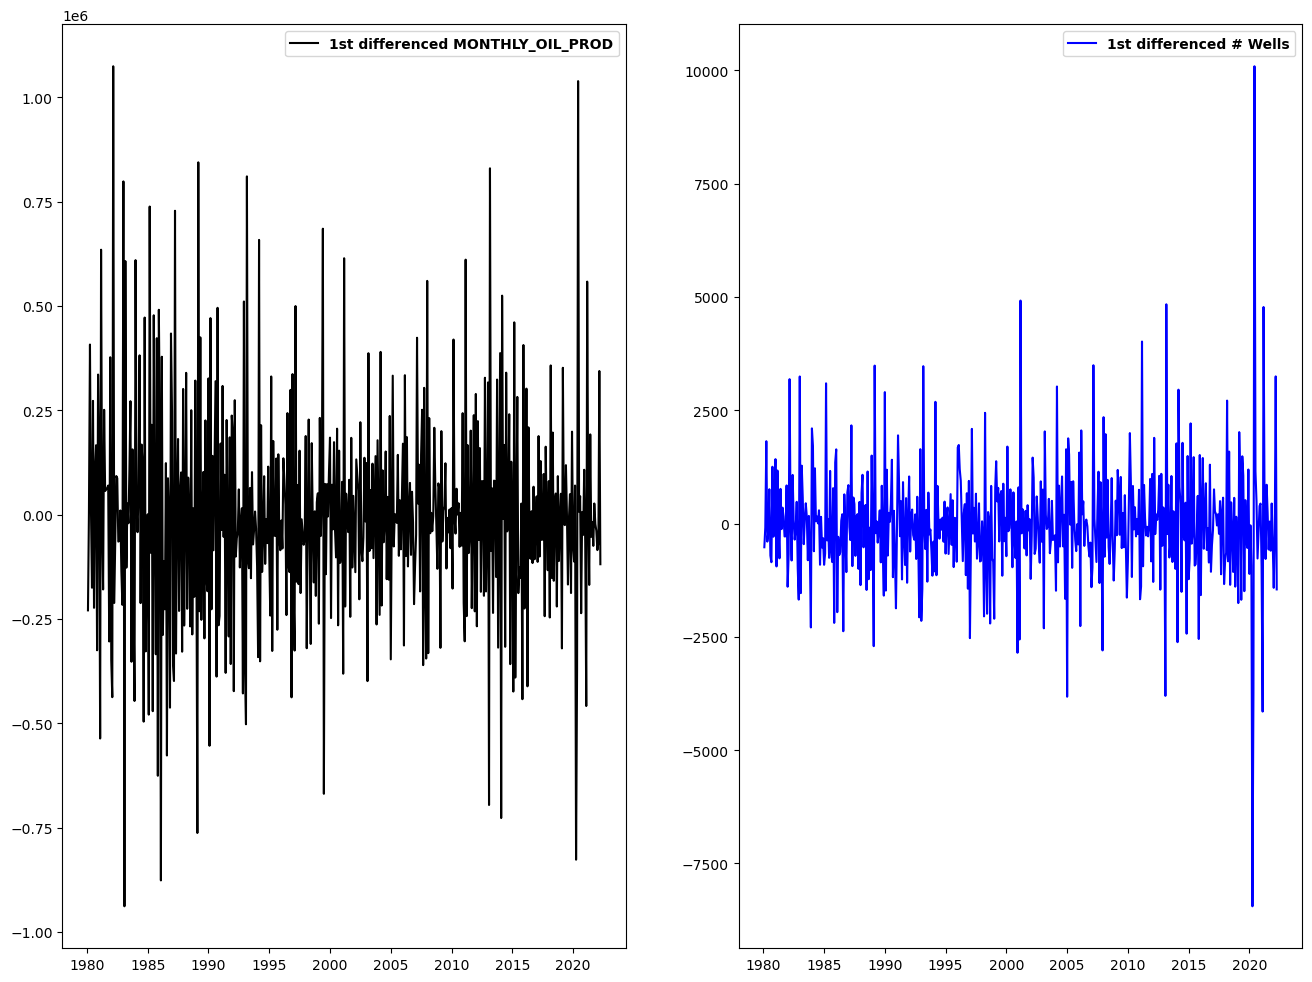

In [15]:
plt.subplot(1, 2, 2)

plt.subplot(1, 2, 1)
plt.plot(df_diff['MONTHLY_OIL_PROD'], color='black', label='1st differenced MONTHLY_OIL_PROD')
plt.legend(loc='upper right', fontsize=12, prop=legend_properties)

plt.subplot(1, 2, 2)
plt.plot(df_diff['N_WELLS'], color='blue', label='1st differenced # Wells')
plt.legend(loc='upper right', fontsize=12, prop=legend_properties)
plt.show()

In [16]:
adfuller_test(df_diff['MONTHLY_OIL_PROD'], 'MONTHLY_OIL_PROD')

    Augmented Dickey-Fuller Test on "MONTHLY_OIL_PROD" 

 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.2588
 No. Lags Chosen       = 16
 Critical value 1%     = -3.444
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.0005. Rejecting Null Hypothesis.
 => Series is Stationary.


In [17]:
adfuller_test(df_diff['N_WELLS'], 'N_WELLS')

    Augmented Dickey-Fuller Test on "N_WELLS" 

 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.1814
 No. Lags Chosen       = 11
 Critical value 1%     = -3.444
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


**Granger’s causality tests**

In [18]:
# data for test whether the time series in the second column Granger causes the time series in the first column
print('N_WELLS causes MONTHLY_OIL_PROD?\n')
granger_1 = grangercausalitytests(df_oil_prod[['MONTHLY_OIL_PROD', 'N_WELLS']], maxlag=3)

N_WELLS causes MONTHLY_OIL_PROD?


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.7852  , p=0.0095  , df_denom=504, df_num=1
ssr based chi2 test:   chi2=6.8255  , p=0.0090  , df=1
likelihood ratio test: chi2=6.7800  , p=0.0092  , df=1
parameter F test:         F=6.7852  , p=0.0095  , df_denom=504, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.9724  , p=0.0001  , df_denom=501, df_num=2
ssr based chi2 test:   chi2=18.1238 , p=0.0001  , df=2
likelihood ratio test: chi2=17.8068 , p=0.0001  , df=2
parameter F test:         F=8.9724  , p=0.0001  , df_denom=501, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=15.8493 , p=0.0000  , df_denom=498, df_num=3
ssr based chi2 test:   chi2=48.2163 , p=0.0000  , df=3
likelihood ratio test: chi2=46.0512 , p=0.0000  , df=3
parameter F test:         F=15.8493 , p=0.0000  , df_denom=498, df_num=3


Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero that is past values of one time series data do not cause the other time series.

For 95% CI, if p-value is less than 0.05, can reject the null hypothesis.

Here p-value is less than 0.05 for lag 2 and 3, so N_WELLS causes MONTHLY_OIL_PROD.

In [19]:
# data for test whether the time series in the second column Granger causes the time series in the first column
print('MONTHLY_OIL_PROD causes N_WELLS?\n')
granger_2 = grangercausalitytests(df_oil_prod[['N_WELLS', 'MONTHLY_OIL_PROD']], maxlag=3)

MONTHLY_OIL_PROD causes N_WELLS?


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0693  , p=0.0141  , df_denom=504, df_num=1
ssr based chi2 test:   chi2=6.1055  , p=0.0135  , df=1
likelihood ratio test: chi2=6.0690  , p=0.0138  , df=1
parameter F test:         F=6.0693  , p=0.0141  , df_denom=504, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=11.3324 , p=0.0000  , df_denom=501, df_num=2
ssr based chi2 test:   chi2=22.8910 , p=0.0000  , df=2
likelihood ratio test: chi2=22.3883 , p=0.0000  , df=2
parameter F test:         F=11.3324 , p=0.0000  , df_denom=501, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=17.7828 , p=0.0000  , df_denom=498, df_num=3
ssr based chi2 test:   chi2=54.0984 , p=0.0000  , df=3
likelihood ratio test: chi2=51.3924 , p=0.0000  , df=3
parameter F test:         F=17.7828 , p=0.0000  , df_denom=498, df_num=3


Even though Granger Causality indicates MONTHLY_GAS_PROD causes N_WELLS which is not totally logical. Lets start with Univariate time series models.

**Train & Test Split**

In [20]:
# 36 months of data is used as test data
test_obs = 36

xtrain, xvalid = model_selection.train_test_split(df_oil_prod, test_size = test_obs)
print(xtrain.shape, xvalid.shape)

(472, 2) (36, 2)


**Exponential Smoothing (Triple Exponential Smoothing)** - smoothed series is a simple weighted average of the past and the present

In [21]:
fit1 = ExponentialSmoothing(xtrain['MONTHLY_OIL_PROD'].values, seasonal_periods = 12, trend = 'add', seasonal = 'add', 
                            use_boxcox=True)
fit1 = fit1.fit()

In [22]:
fit1.params_formatted

,name,param,optimized
smoothing_level,alpha,3.232143e-01,True
smoothing_trend,beta,6.060268e-02,True
smoothing_seasonal,gamma,5.885093e-02,True
initial_level,l.0,1.037459e+00,True
initial_trend,b.0,2.724245e-09,True
initial_seasons.0,s.0,4.907719e-09,True
initial_seasons.1,s.1,-2.400309e-08,True
initial_seasons.2,s.2,7.384762e-09,True
initial_seasons.3,s.3,2.614352e-09,True
initial_seasons.4,s.4,2.186313e-09,True


c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


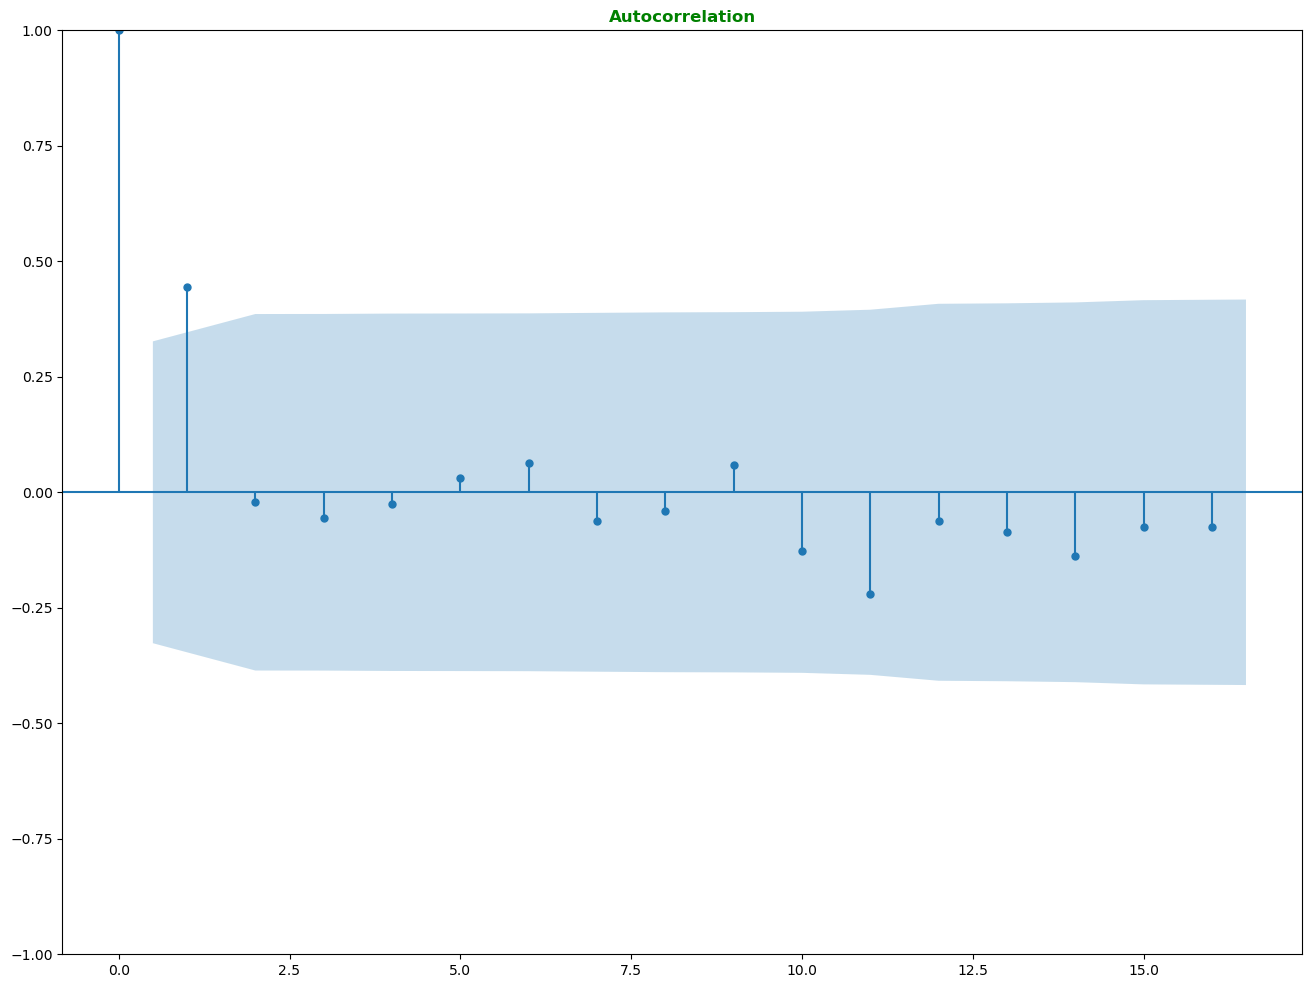

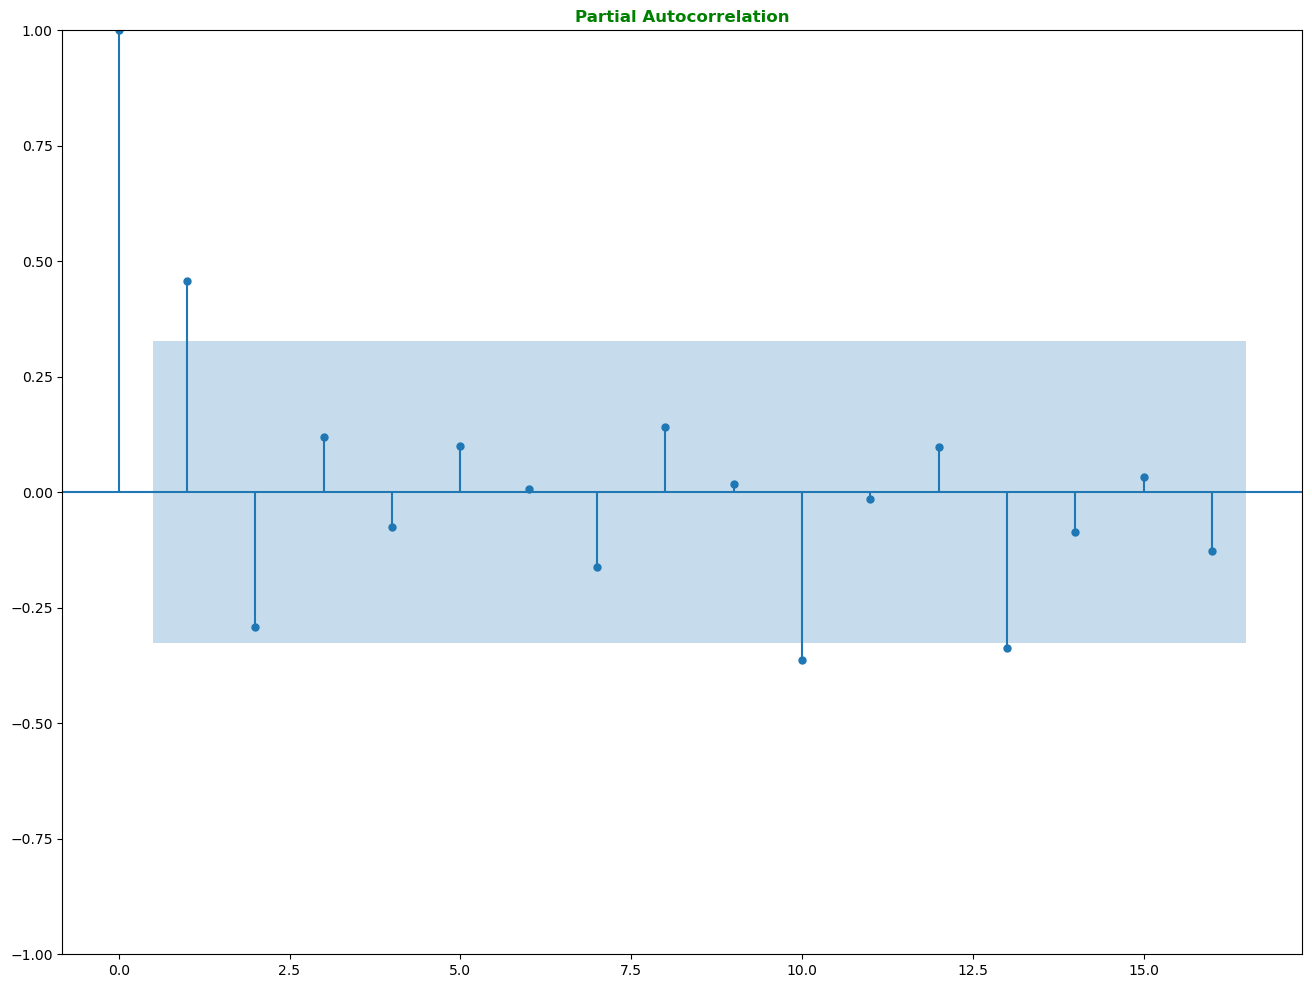

In [23]:
prediction_hw = fit1.forecast(len(xvalid)).copy()

xresiduals = xvalid['MONTHLY_OIL_PROD'] - prediction_hw
plot_acf(xresiduals)
print()

plot_pacf(xresiduals)
print()

Some lags are outside of 95% confidence band.

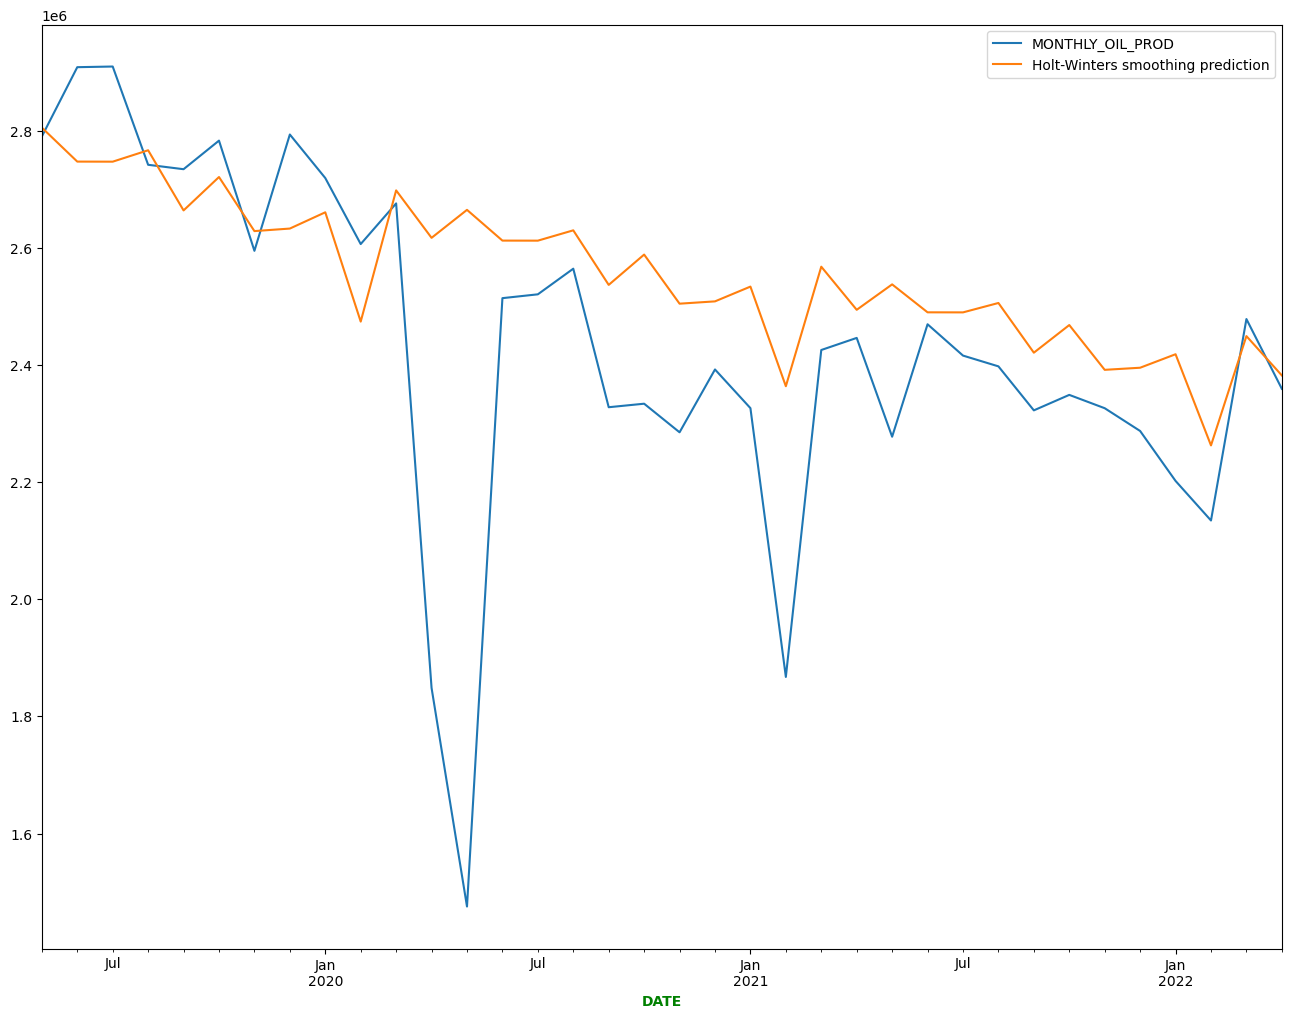

In [24]:
pd.DataFrame({'MONTHLY_OIL_PROD':xvalid['MONTHLY_OIL_PROD'],'Holt-Winters smoothing prediction':prediction_hw}).plot()
plt.show()

Exponential Smoothing did a decent job in capturing the trend but overall prediction is higher than the actual.

Since there is seaonality, lets try SARIMA

**SARIMA (Seasonal ARIMA) Model**

In [25]:
model_sarima = auto_arima(xtrain['MONTHLY_OIL_PROD'], start_p=0, d= 1, start_q=0,
                          start_P=0, D=1, start_Q=0, m= 12,
                          seasonal=True, test='adf', stepwise=True,
                          trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=12787.582, Time=0.18 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=12708.837, Time=0.29 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=12622.956, Time=0.32 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=12728.204, Time=0.12 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.48 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=1.15 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=12696.568, Time=0.30 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.20 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=12679.276, Time=0.30 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=12624.656, Time=0.38 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=12624.381, Time=0.39 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=12631.889, Time=0.33 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=12622.006, Time=0.70 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=inf, Time=0.66 sec
 ARIMA(1,1,2)(1,1,1)[12]     

In [26]:
print(model_sarima.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  472
Model:             SARIMAX(2, 1, 3)x(0, 1, [1, 2], 12)   Log Likelihood               -6252.121
Date:                                 Sat, 26 Nov 2022   AIC                          12520.242
Time:                                         13:23:04   BIC                          12553.275
Sample:                                     01-01-1980   HQIC                         12533.251
                                          - 04-01-2019                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1501      0.007   -164.367      0.000      -1.164      -1

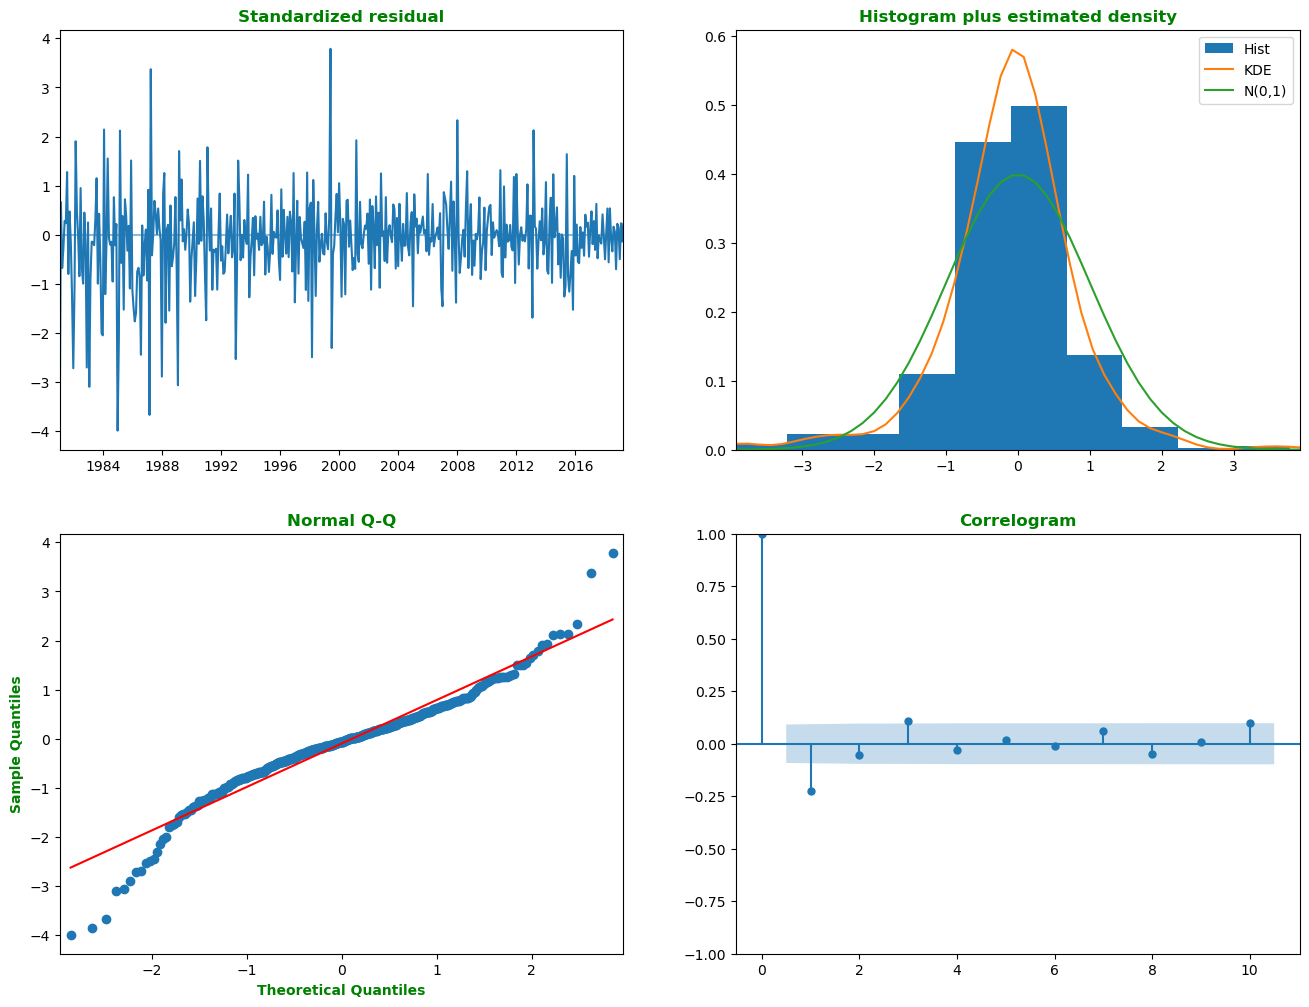

In [27]:
model_sarima.plot_diagnostics()
plt.show()

In [28]:
fitted, confint = model_sarima.predict(xvalid['MONTHLY_OIL_PROD'].shape[0], return_conf_int=True, alpha=0.05)
lower_conf = pd.Series(confint[:, 0], index=xvalid.index)
lower_conf[lower_conf < 0] = 0
upper_conf = pd.Series(confint[:, 1], index=xvalid.index)

hw_pred = pd.Series(prediction_hw, index=xvalid.index)

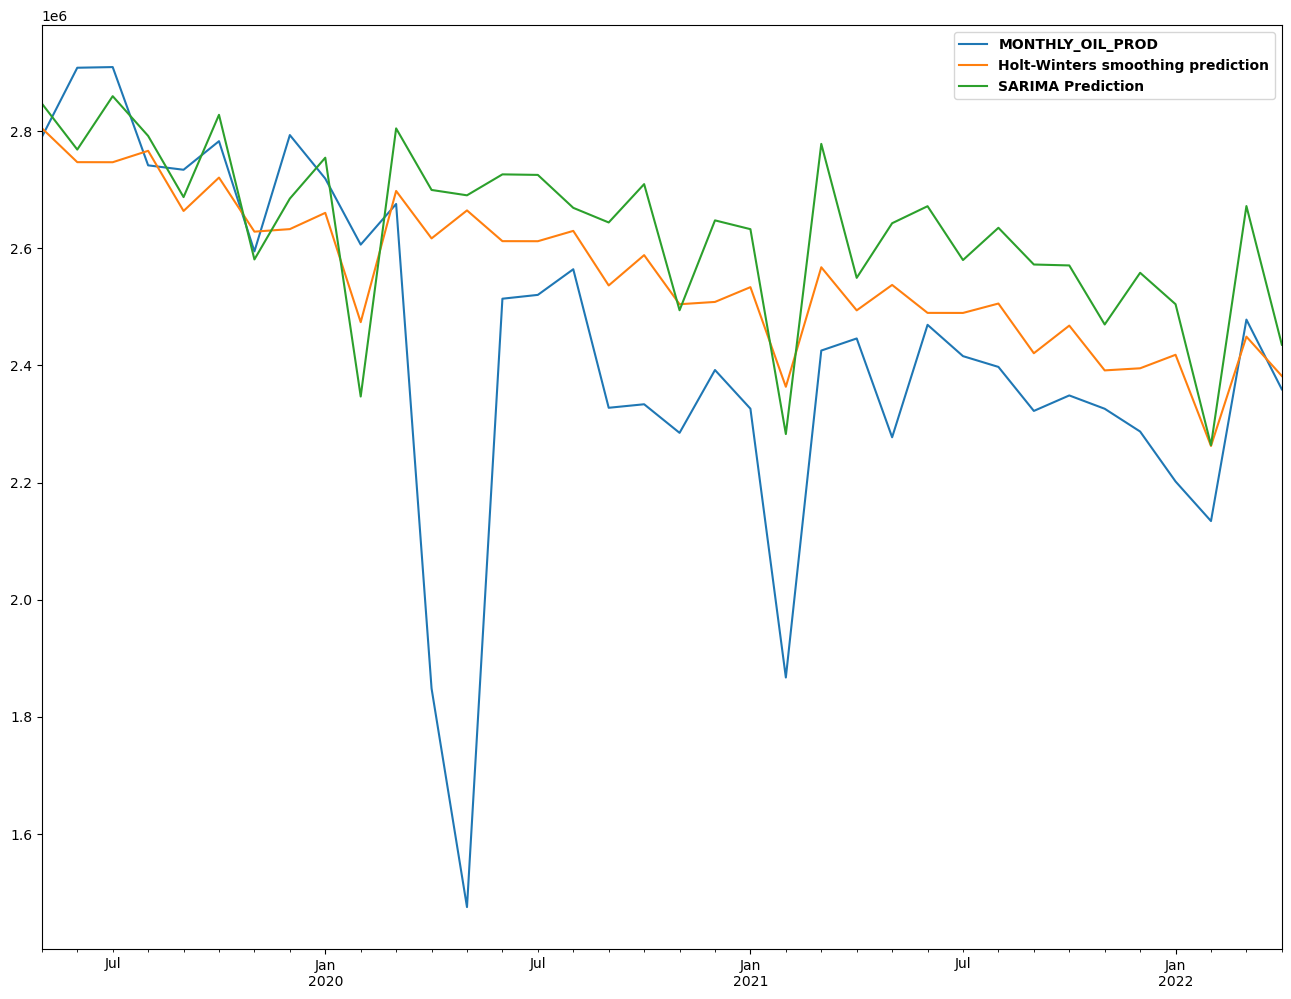

In [29]:
pd.DataFrame({'MONTHLY_OIL_PROD':xvalid['MONTHLY_OIL_PROD'],
              'Holt-Winters smoothing prediction':prediction_hw,
              'SARIMA Prediction':fitted}).plot()
plt.legend(prop=legend_properties)
plt.show()

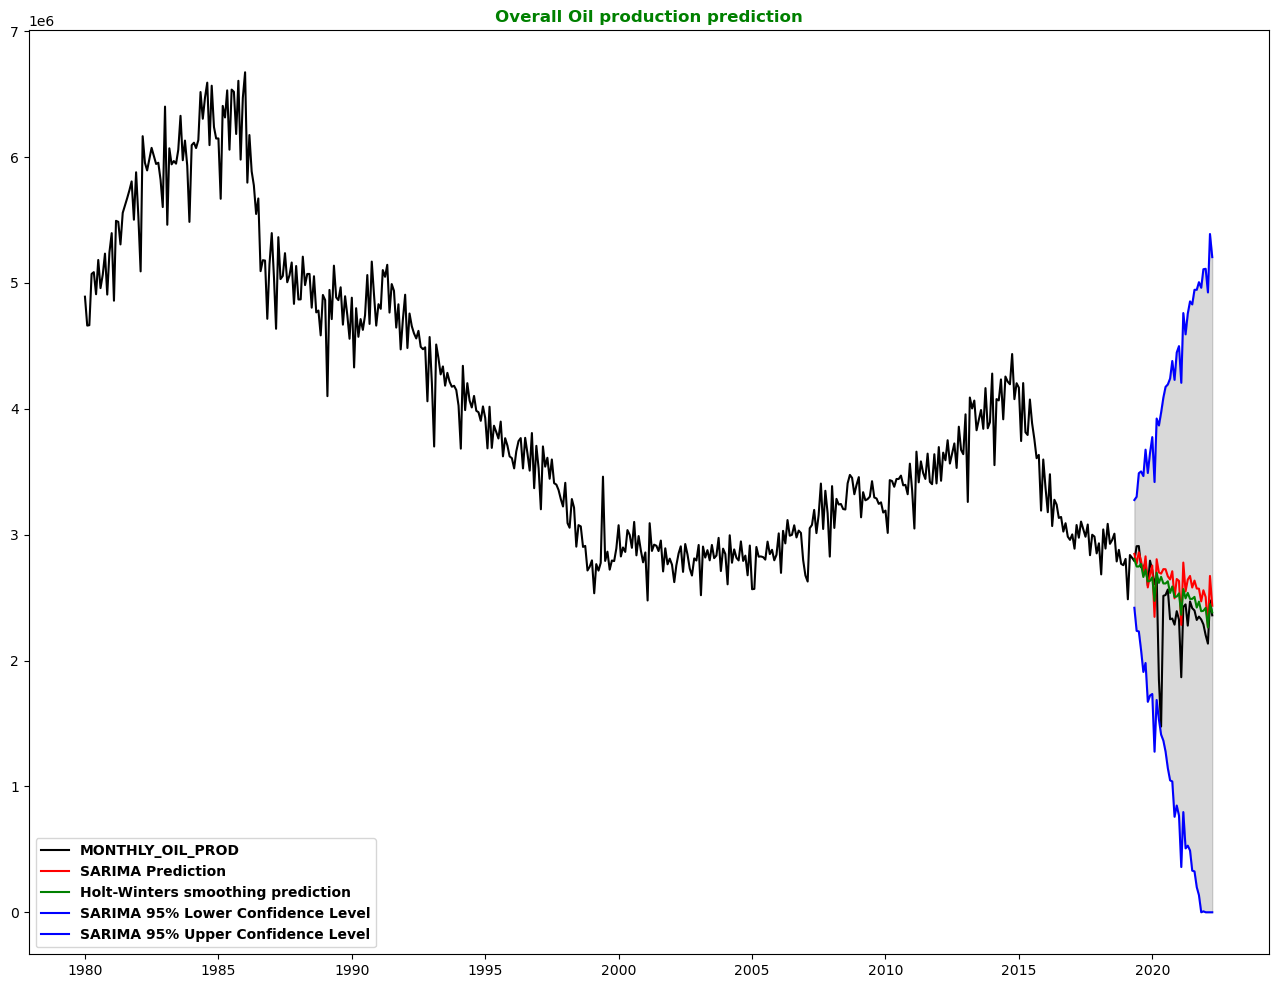

In [30]:
plt.plot(df_oil_prod['MONTHLY_OIL_PROD'], color='black', label='MONTHLY_OIL_PROD')
plt.plot(pd.Series(fitted), color='red', label='SARIMA Prediction')
plt.plot(hw_pred, color='green', label='Holt-Winters smoothing prediction')
plt.plot(lower_conf, color='blue', label='SARIMA 95% Lower Confidence Level')
plt.plot(upper_conf, color='blue', label='SARIMA 95% Upper Confidence Level')
plt.fill_between(lower_conf.index, 
                 lower_conf, 
                 upper_conf, 
                 color='k', alpha=.15)
plt.title('Overall Oil production prediction')
plt.legend(loc='lower left', fontsize=14, prop=legend_properties)
plt.show()

**SARIMAX (Seasonal ARIMA with Exogeneous Time Series)**

number of wells used as exogeneous predictor

In [31]:
model_sarimax = auto_arima(xtrain['MONTHLY_OIL_PROD'], X= xtrain[['N_WELLS']], start_p=0, d= 1, start_q=0,
                          start_P=0, D=1, start_Q=0, m= 12,
                          seasonal=True, test='adf', stepwise=True,
                          trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=14760.318, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=12228.384, Time=0.61 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=12116.290, Time=0.59 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=12279.129, Time=0.27 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.82 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=2.39 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=12217.233, Time=0.62 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.54 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.37 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=12109.515, Time=0.85 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=12274.768, Time=0.22 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=1.11 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=inf, Time=2.42 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=12210.192, Time=0.79 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AI

In [32]:
print(model_sarimax.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  472
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 12)   Log Likelihood               -6046.123
Date:                              Sat, 26 Nov 2022   AIC                          12102.246
Time:                                      13:23:43   BIC                          12122.891
Sample:                                  01-01-1980   HQIC                         12110.376
                                       - 04-01-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
N_WELLS      145.4155      4.164     34.925      0.000     137.255     153.576
ar.L1         -0.62

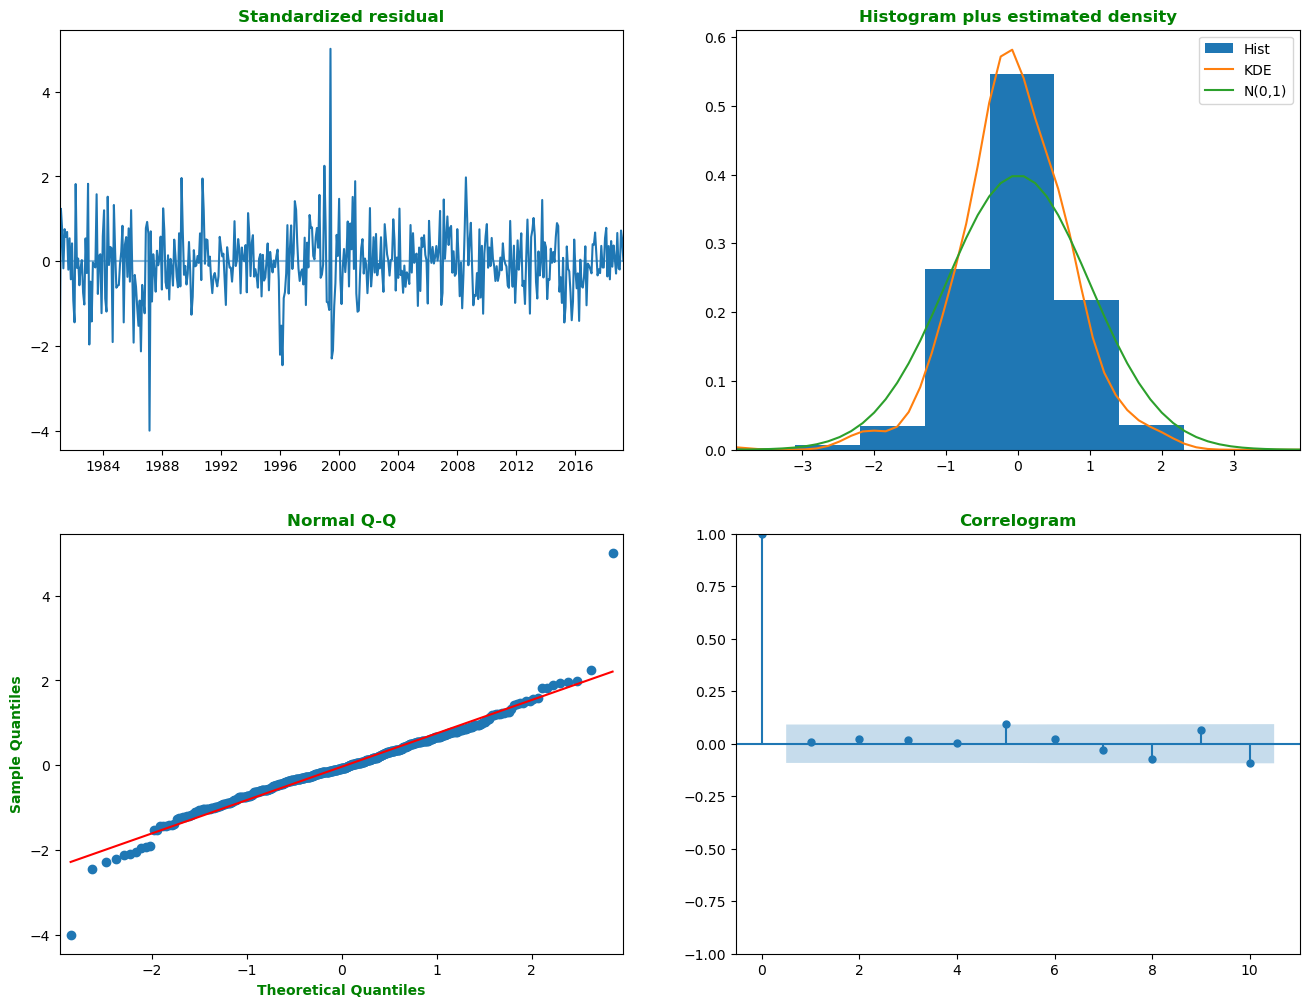

In [33]:
model_sarimax.plot_diagnostics()
plt.show()

In [34]:
fittedx, confintx = model_sarimax.predict(xvalid['MONTHLY_OIL_PROD'].shape[0], X = xvalid[['N_WELLS']], 
                                          return_conf_int=True, alpha=0.05)
lower_confx = pd.Series(confintx[:, 0], index=xvalid.index)
lower_confx[lower_confx < 0] = 0
upper_confx = pd.Series(confintx[:, 1], index=xvalid.index)

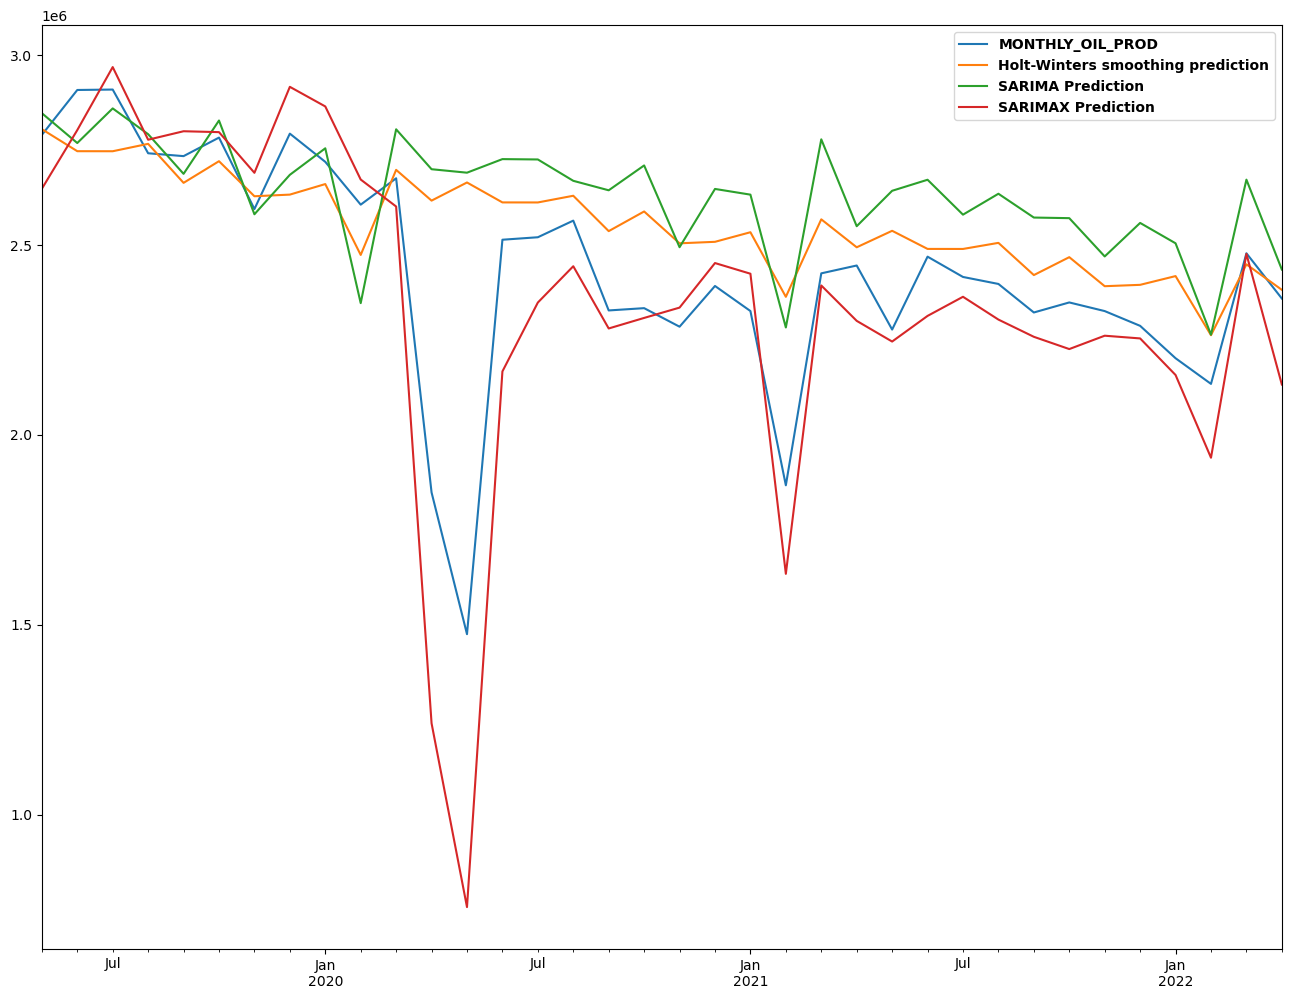

In [35]:
pd.DataFrame({'MONTHLY_OIL_PROD':xvalid['MONTHLY_OIL_PROD'],
              'Holt-Winters smoothing prediction':prediction_hw,
              'SARIMA Prediction':fitted,
              'SARIMAX Prediction':fittedx}).plot()
plt.legend(prop=legend_properties)
plt.show()

In [36]:
plt_df = pd.DataFrame({'MONTHLY_OIL_PROD':xvalid['MONTHLY_OIL_PROD'],
              'Holt-Winters smoothing prediction':prediction_hw,
              'SARIMA Prediction':fitted,
              'SARIMAX Prediction':fittedx})
plt_df

,MONTHLY_OIL_PROD,Holt-Winters smoothing prediction,SARIMA Prediction,SARIMAX Prediction
2019-05-01,2789835.60,2.804929e+06,2.847033e+06,2.647958e+06
2019-06-01,2908116.46,2.746947e+06,2.768438e+06,2.802465e+06
2019-07-01,2909243.28,2.746830e+06,2.859587e+06,2.968412e+06
2019-08-01,2741500.17,2.766296e+06,2.791753e+06,2.777150e+06
2019-09-01,2733964.30,2.663605e+06,2.687294e+06,2.799480e+06
2019-10-01,2782754.43,2.720616e+06,2.827743e+06,2.797116e+06
2019-11-01,2594642.66,2.628326e+06,2.580884e+06,2.690046e+06
2019-12-01,2793200.69,2.632646e+06,2.684739e+06,2.916408e+06
2020-01-01,2718905.75,2.660400e+06,2.754555e+06,2.864787e+06
2020-02-01,2606186.10,2.473821e+06,2.346904e+06,2.672327e+06


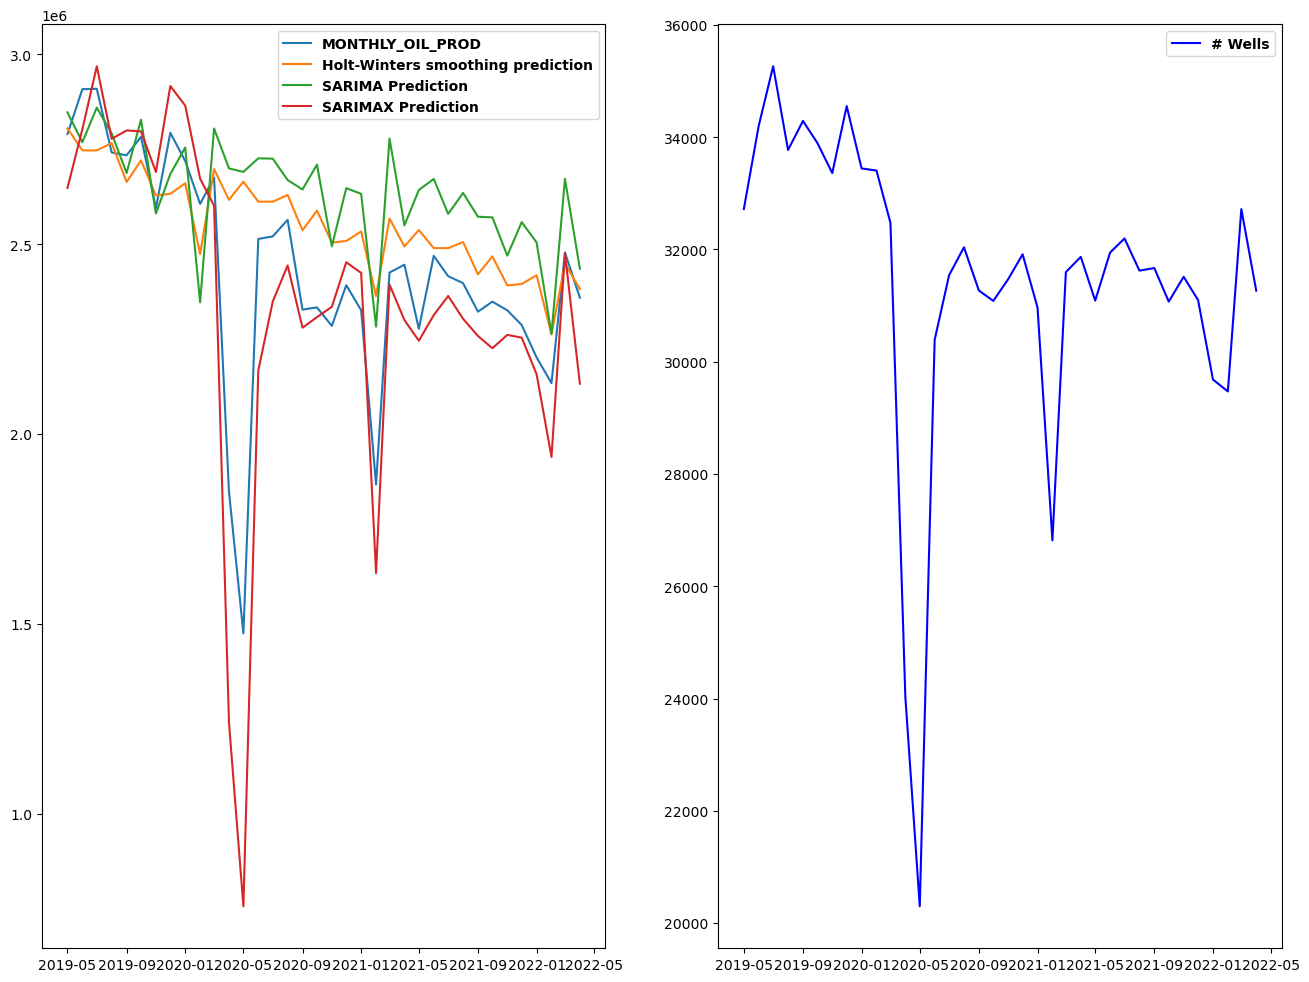

In [37]:
plt.subplot(1, 2, 2)

plt.subplot(1, 2, 1)
for i, c in enumerate(plt_df):
    plt.plot(plt_df[c], label=c)
plt.legend(loc='upper right', fontsize=8, prop=legend_properties)

plt.subplot(1, 2, 2)
plt.plot(xvalid['N_WELLS'], color='blue', label='# Wells')
plt.legend(loc='upper right', fontsize=8, prop=legend_properties)
plt.show()

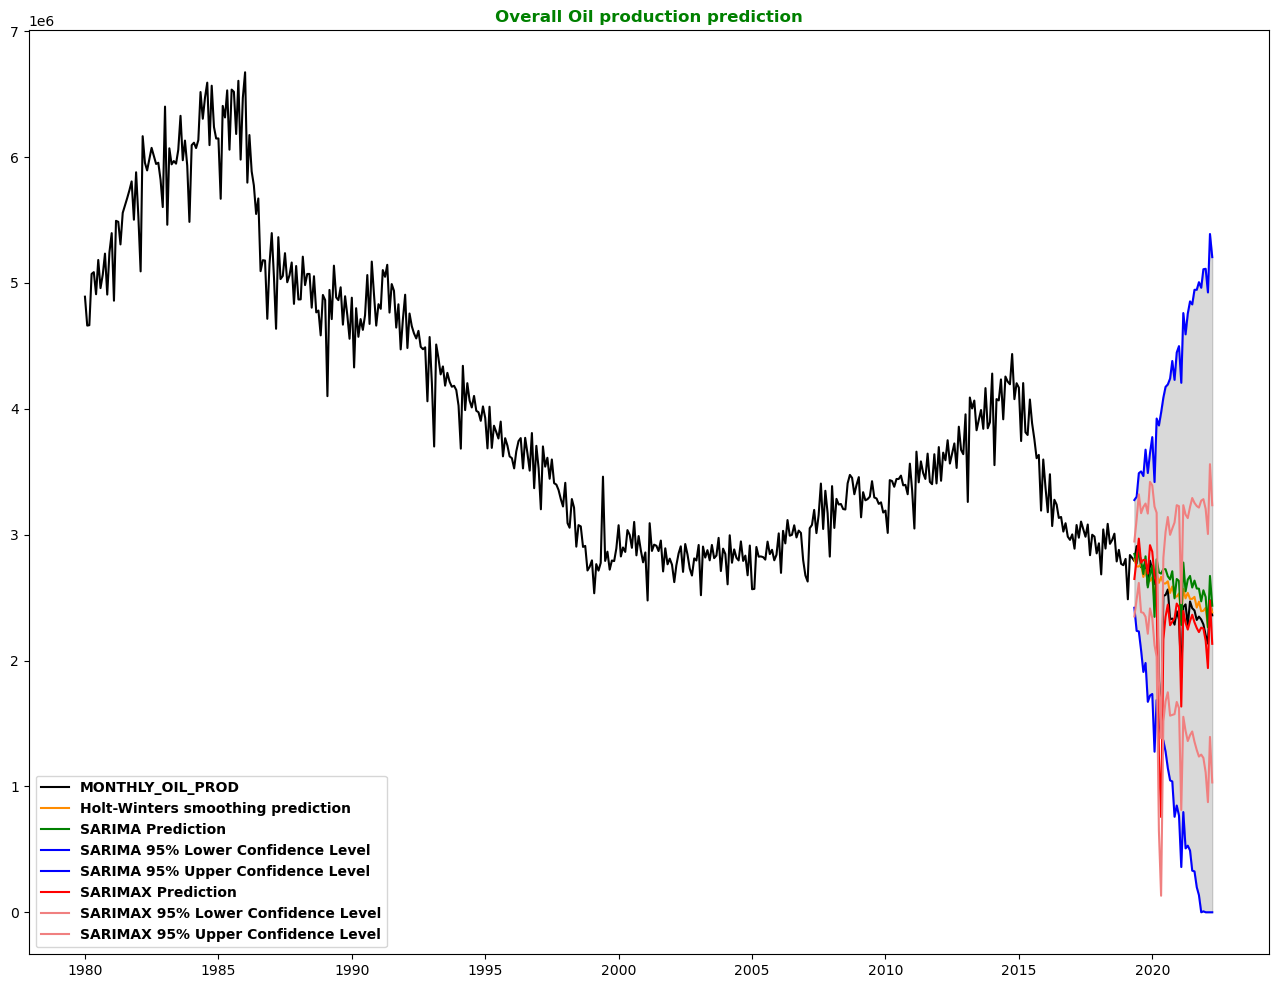

In [38]:
plt.plot(df_oil_prod['MONTHLY_OIL_PROD'], color='black', label='MONTHLY_OIL_PROD')

plt.plot(hw_pred, color='darkorange', label='Holt-Winters smoothing prediction')

plt.plot(pd.Series(fitted), color='green', label='SARIMA Prediction')
plt.plot(lower_conf, color='blue', label='SARIMA 95% Lower Confidence Level')
plt.plot(upper_conf, color='blue', label='SARIMA 95% Upper Confidence Level')

plt.plot(pd.Series(fittedx), color='red', label='SARIMAX Prediction')
plt.plot(lower_confx, color='lightcoral', label='SARIMAX 95% Lower Confidence Level')
plt.plot(upper_confx, color='lightcoral', label='SARIMAX 95% Upper Confidence Level')


plt.fill_between(lower_conf.index, 
                 lower_conf, 
                 upper_conf, 
                 color='k', alpha=.15)
plt.title('Overall Oil production prediction')
plt.legend(loc='lower left', fontsize=16, prop=legend_properties)
plt.show()

SARIMAX performed better than SARIMA for Oil Production prediction.

According to the domain expert, production should change as number of wells change which we are seeing in oil production. As a result, SARIMAX which uses number of wells as one of the predictors performing well as oil production drops according to number of wells, and hence SARIMAX is doing much better. To confirm model choices, lets do 5-fold cross validation or what we call as Walk Forward Validation for time series data.

**Walk Forward Validation via TimeSeriesSplit**

Observations: 160
Training Observations: 82
Testing Observations: 78
Observations: 238
Training Observations: 160
Testing Observations: 78
Observations: 316
Training Observations: 238
Testing Observations: 78
Observations: 394
Training Observations: 316
Testing Observations: 78
Observations: 472
Training Observations: 394
Testing Observations: 78


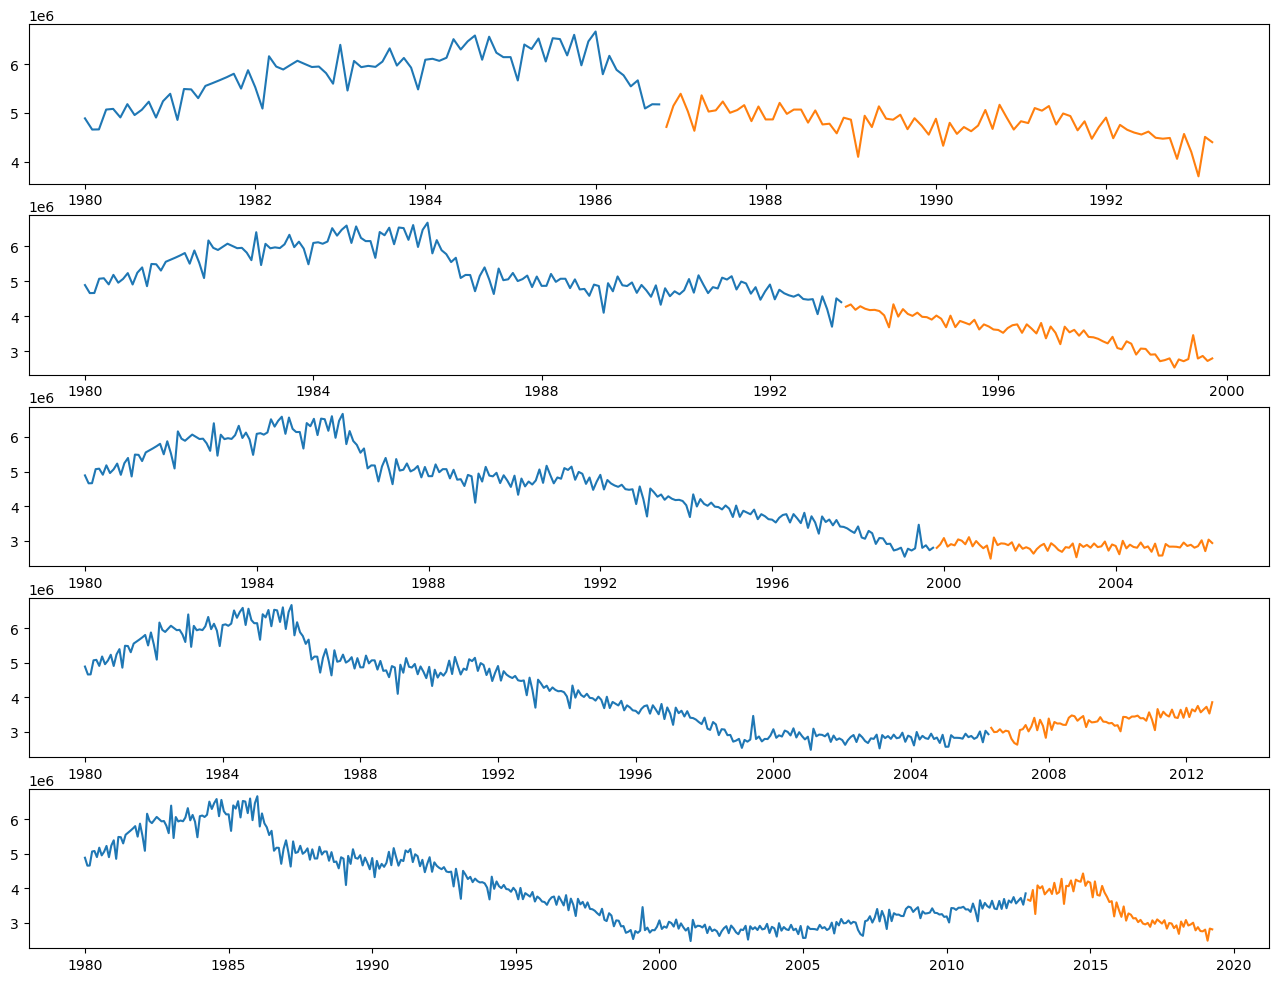

In [39]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits)

plt.figure(1)
index = 1
for train_index, test_index in tscv.split(xtrain):
	train_cv = xtrain.iloc[train_index,:]
	test_cv = xtrain.iloc[test_index, :]
	print('Observations: %d' % (len(train_cv) + len(test_cv)))
	print('Training Observations: %d' % (len(train_cv)))
	print('Testing Observations: %d' % (len(test_cv)))
	plt.subplot(510 + index)
	plt.plot(train_cv['MONTHLY_OIL_PROD'])
	plt.plot(test_cv['MONTHLY_OIL_PROD'])
	index += 1
plt.show()

**SARIMA with Walk Forward Validation**

 ARIMA(0,1,0)(0,1,0)[12]          
 ARIMA(0,1,1)(0,1,2)[12]          
 ARIMA(0,1,1)(0,1,2)[12] intercept
 ARIMA(0,1,1)(0,1,2)[12]          
 ARIMA(2,1,3)(0,1,2)[12]          


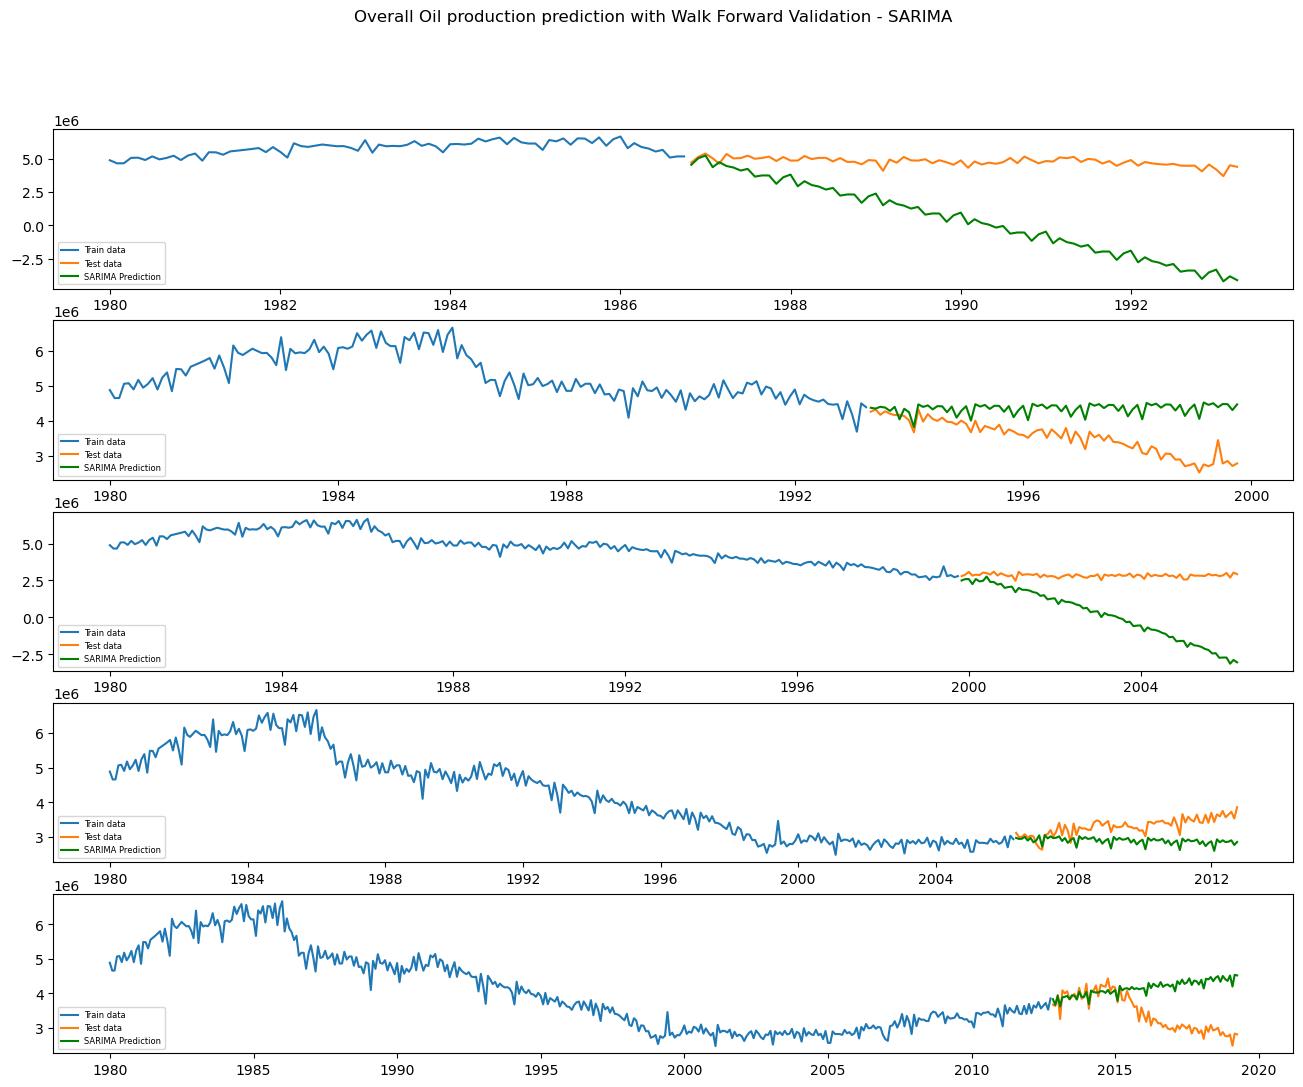

[5035171.7413966535, 953200.4440299922, 3174300.4735128446, 497233.5338617625, 987044.5591554358]


In [40]:

plt.figure(1)
index = 1

rmse_sarima_cv = []

for train_index, test_index in tscv.split(xtrain):
	
	train_cv = xtrain.iloc[train_index,:]
	test_cv = xtrain.iloc[test_index, :]


	model_sarima_cv = auto_arima(train_cv['MONTHLY_OIL_PROD'], start_p=0, d= 1, start_q=0,
                          start_P=0, D=1, start_Q=0, m= 12,
                          seasonal=True, test='adf', stepwise=True,
                          trace=False, error_action='ignore', suppress_warnings=True)
	
	print(model_sarima_cv)
	
	fitted_cv, confint_cv = model_sarima_cv.predict(test_cv['MONTHLY_OIL_PROD'].shape[0], return_conf_int=True, alpha=0.05)
	lower_conf_cv = pd.Series(confint_cv[:, 0], index=fitted_cv.index)
	upper_conf_cv = pd.Series(confint_cv[:, 1], index=fitted_cv.index)


	rmse_sarima_cv.append(np.sqrt(mean_squared_error(fitted_cv, test_cv['MONTHLY_OIL_PROD'])))


	plt.subplot(510 + index)
	plt.plot(train_cv['MONTHLY_OIL_PROD'], label='Train data')
	plt.plot(test_cv['MONTHLY_OIL_PROD'], label='Test data')
	plt.plot(pd.Series(fitted_cv), color='green', label='SARIMA Prediction')
	#plt.plot(lower_conf_cv, color='blue', label='SARIMA 95% Lower Confidence Level')
	#plt.plot(upper_conf_cv, color='blue', label='SARIMA 95% Upper Confidence Level')
	plt.legend(loc='lower left', fontsize=6)

	index += 1

plt.suptitle('Overall Oil production prediction with Walk Forward Validation - SARIMA')
plt.show()


print(rmse_sarima_cv)

**SARIMAX with Walk Forward Validation**

 ARIMA(0,1,2)(0,1,2)[12]          
 ARIMA(0,1,2)(0,1,2)[12]          
 ARIMA(1,1,2)(2,1,1)[12]          
 ARIMA(2,1,0)(0,1,1)[12]          
 ARIMA(2,1,0)(0,1,2)[12]          


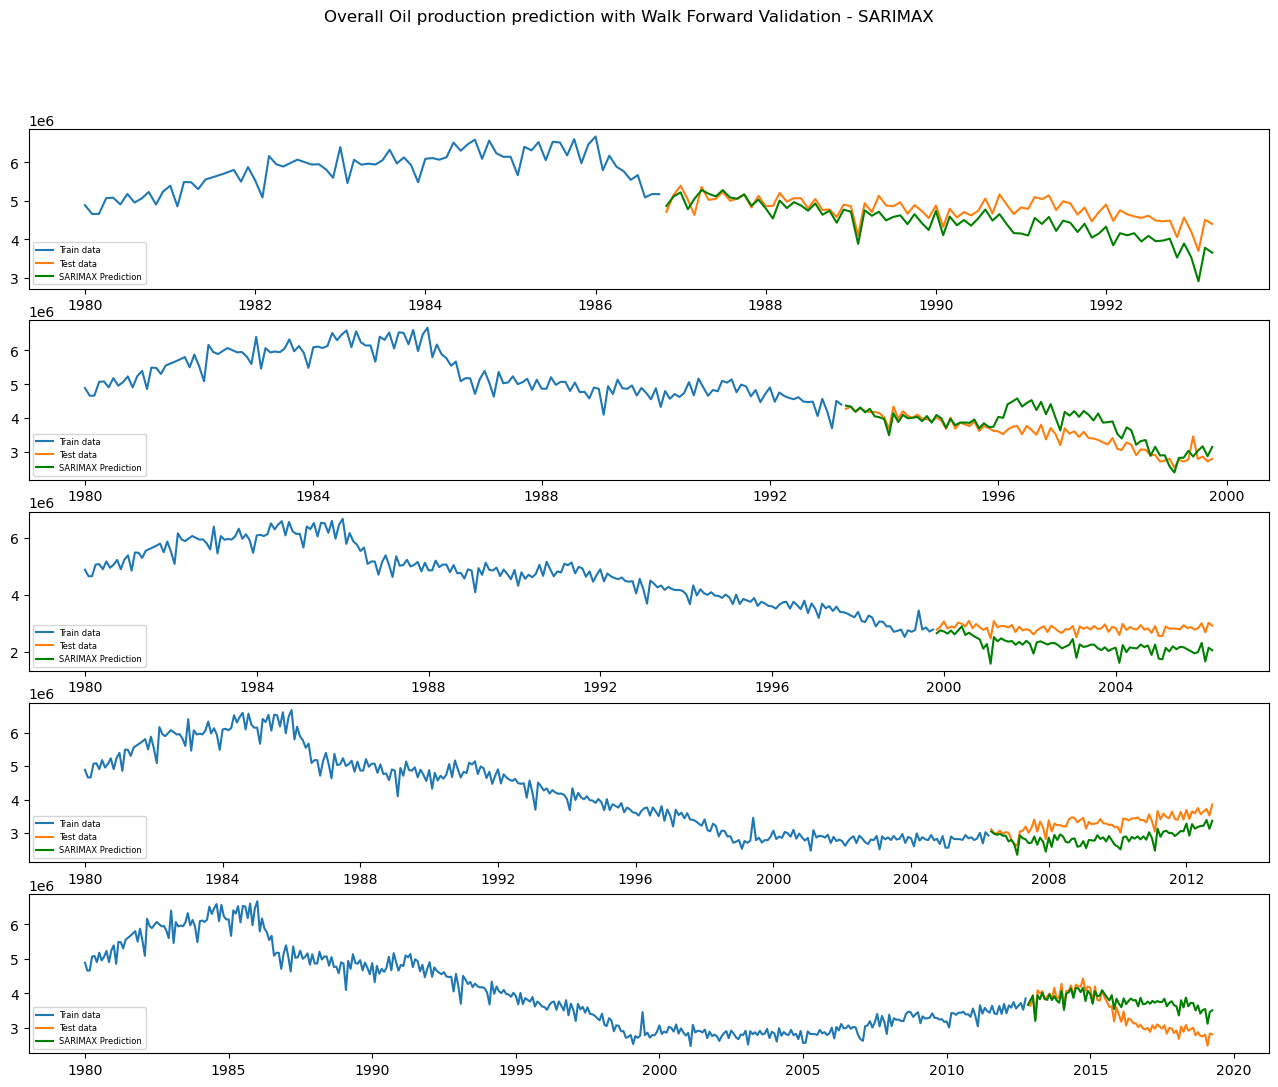

[396598.89406685147, 402958.11458487745, 622355.6124636318, 466588.7360891168, 511021.016683346]


In [41]:

plt.figure(1)
index = 1

rmse_sarimax_cv = []

for train_index, test_index in tscv.split(xtrain):
	
	train_cv = xtrain.iloc[train_index,:]
	test_cv = xtrain.iloc[test_index, :]


	model_sarimax_cv = auto_arima(train_cv['MONTHLY_OIL_PROD'], X= train_cv[['N_WELLS']], start_p=0, d= 1, start_q=0,
                          start_P=0, D=1, start_Q=0, m= 12,
                          seasonal=True, test='adf', stepwise=True,
                          trace=False, error_action='ignore', suppress_warnings=True)

	print(model_sarimax_cv)

	fittedx_cv, confintx_cv = model_sarimax_cv.predict(test_cv['MONTHLY_OIL_PROD'].shape[0], X = test_cv[['N_WELLS']], 
											return_conf_int=True, alpha=0.05)
	lower_confx_cv = pd.Series(confintx_cv[:, 0], index=fittedx_cv.index)
	upper_confx_cv = pd.Series(confintx_cv[:, 1], index=fittedx_cv.index)	
	
	rmse_sarimax_cv.append(np.sqrt(mean_squared_error(fittedx_cv, test_cv['MONTHLY_OIL_PROD'])))


	plt.subplot(510 + index)
	plt.plot(train_cv['MONTHLY_OIL_PROD'], label='Train data')
	plt.plot(test_cv['MONTHLY_OIL_PROD'], label='Test data')
	plt.plot(pd.Series(fittedx_cv), color='green', label='SARIMAX Prediction')
	#plt.plot(lower_conf_cv, color='blue', label='SARIMA 95% Lower Confidence Level')
	#plt.plot(upper_conf_cv, color='blue', label='SARIMA 95% Upper Confidence Level')
	plt.legend(loc='lower left', fontsize=6)

	index += 1

plt.suptitle('Overall Oil production prediction with Walk Forward Validation - SARIMAX')
plt.show()


print(rmse_sarimax_cv)

**VAR model**

Though VAR model does not make mcuh sense here, tried just to compare the performance.

In [42]:
# Split differenced data into train and test
xtrain_d, xvalid_d = model_selection.train_test_split(df_diff, test_size = test_obs)
print(xtrain_d.shape, xvalid_d.shape)

(471, 2) (36, 2)


In [43]:
model_var = VAR(xtrain_d, freq='MS')
model_ord = model_var.select_order(maxlags=20)
model_ord.summary()

,AIC,BIC,FPE,HQIC
0,38.24,38.26,4.056e+16,38.25
1,37.69,37.74,2.327e+16,37.71
2,37.49,37.58*,1.909e+16,37.52
3,37.49,37.62,1.919e+16,37.54
4,37.50,37.66,1.932e+16,37.56
5,37.50,37.70,1.929e+16,37.58
6,37.50,37.74,1.936e+16,37.60
7,37.49,37.77,1.921e+16,37.60
8,37.48,37.79,1.898e+16,37.60
9,37.48,37.82,1.889e+16,37.61


In [44]:
model_varx = VARMAX(xtrain, order=(14, 0), freq='MS', enforce_stationarity= True)

fitted_model = model_varx.fit(disp=False)
print(fitted_model.summary())

                                  Statespace Model Results                                 
Dep. Variable:     ['N_WELLS', 'MONTHLY_OIL_PROD']   No. Observations:                  472
Model:                                     VAR(14)   Log Likelihood              -14282.153
                                       + intercept   AIC                          28686.306
Date:                             Sat, 26 Nov 2022   BIC                          28939.882
Time:                                     13:29:26   HQIC                         28786.052
Sample:                                 01-01-1980                                         
                                      - 04-01-2019                                         
Covariance Type:                               opg                                         
Ljung-Box (L1) (Q):         420.49, 446.72   Jarque-Bera (JB):         21.17, 50.50
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Hete

In [45]:
n_forecast = test_obs
#start="2022-10-01",end='2023-01-01')
var_predict = fitted_model.get_prediction(start=len(xtrain), end=len(xtrain) + n_forecast-1)

var_predictions = var_predict.predicted_mean
var_predictions.columns=['NWELLS_predicted', 'MONTHLY_OIL_PROD_predicted']

var_CI = var_predict.conf_int(alpha=0.05)

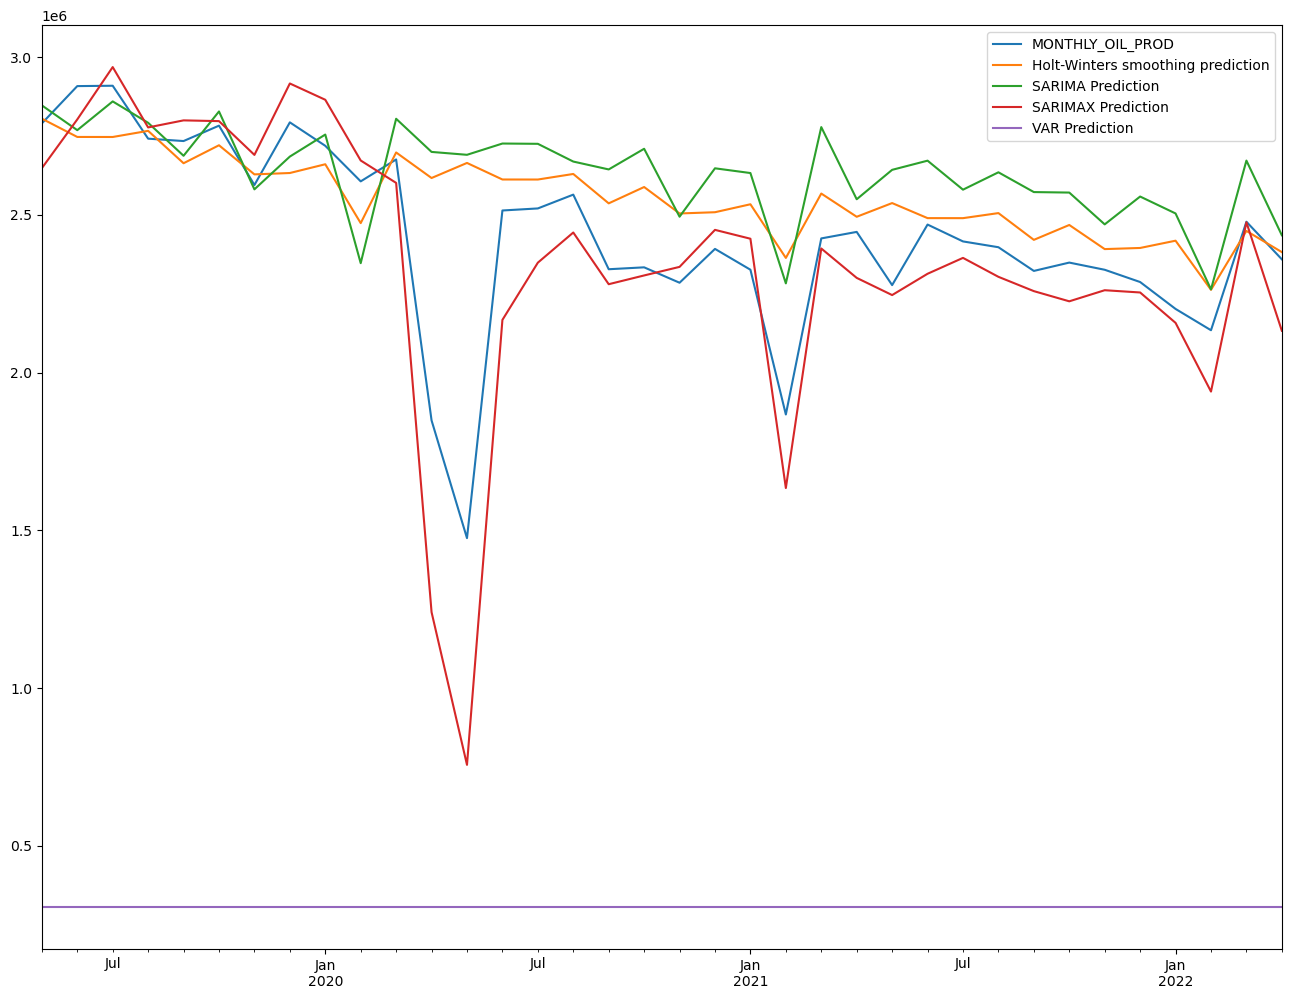

In [46]:
pd.DataFrame({'MONTHLY_OIL_PROD':xvalid['MONTHLY_OIL_PROD'],
              'Holt-Winters smoothing prediction':prediction_hw,
              'SARIMA Prediction':fitted,
              'SARIMAX Prediction':fittedx,
              'VAR Prediction':var_predictions['MONTHLY_OIL_PROD_predicted']}).plot()
plt.show()

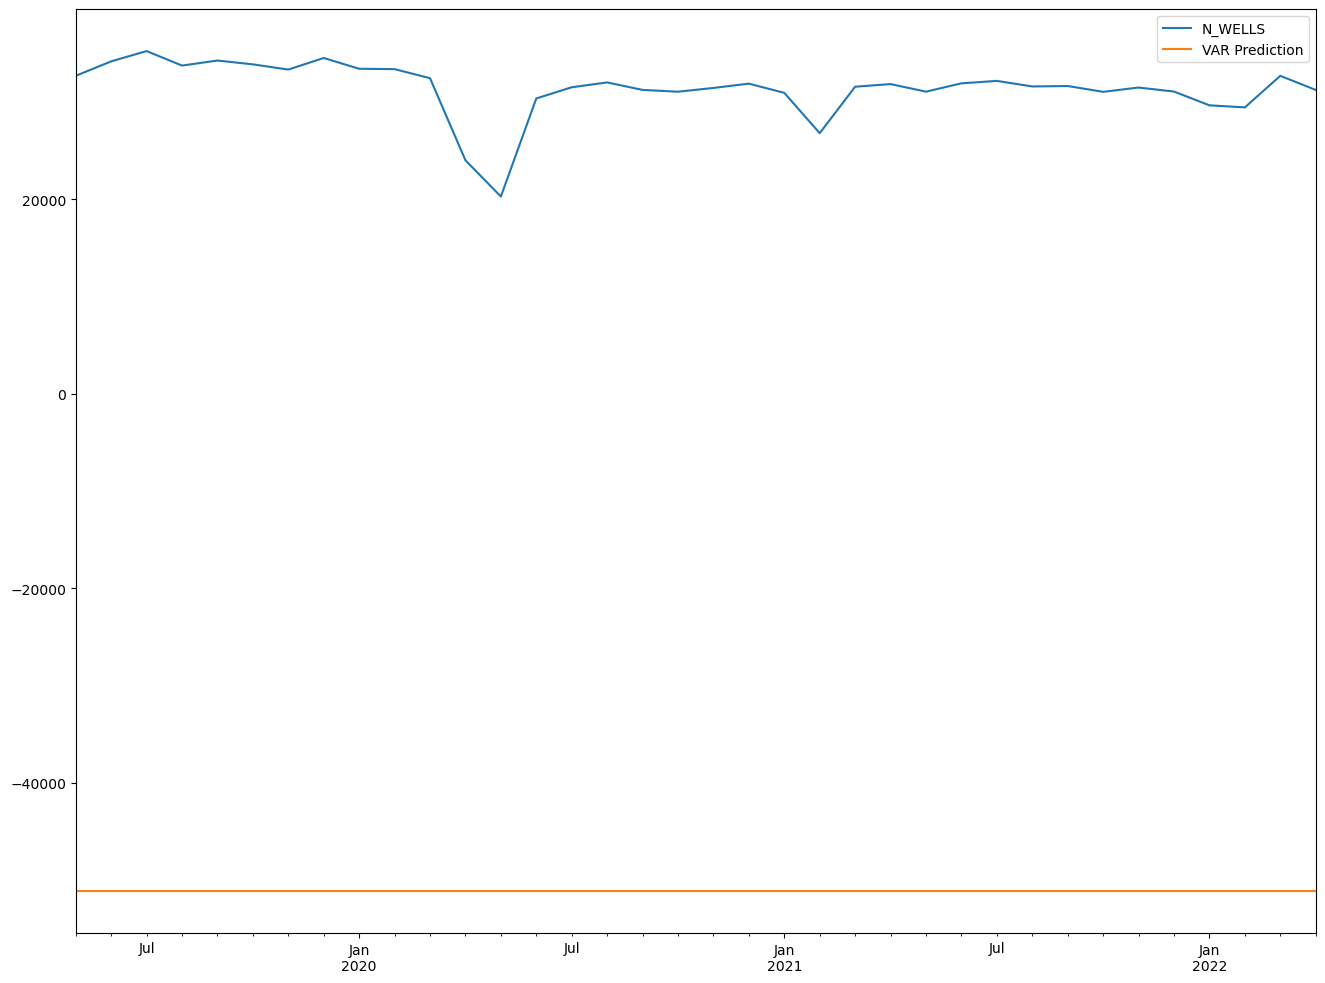

In [47]:
pd.DataFrame({'N_WELLS':xvalid['N_WELLS'],
              'VAR Prediction':var_predictions['NWELLS_predicted']}).plot()
plt.show()

In [48]:
lower_conf_var = pd.Series(var_CI['lower MONTHLY_OIL_PROD'], index=xvalid.index)
upper_conf_var = pd.Series(var_CI['upper MONTHLY_OIL_PROD'], index=xvalid.index)

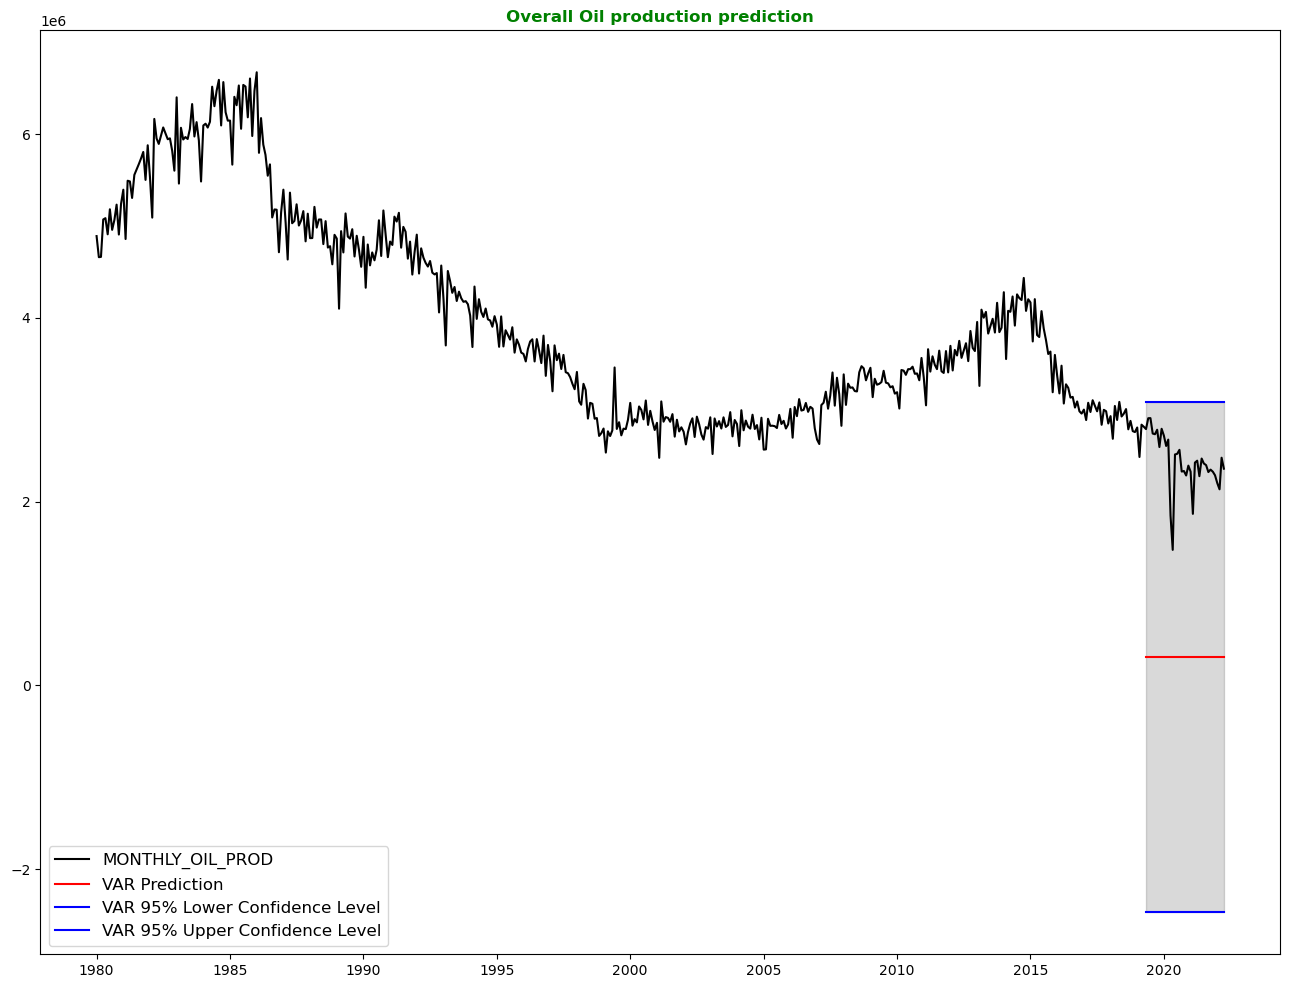

In [49]:
plt.plot(df_oil_prod['MONTHLY_OIL_PROD'], color='black', label='MONTHLY_OIL_PROD')
plt.plot(pd.Series(var_predictions['MONTHLY_OIL_PROD_predicted']), color='red', label='VAR Prediction')
plt.plot(lower_conf_var, color='blue', label='VAR 95% Lower Confidence Level')
plt.plot(upper_conf_var, color='blue', label='VAR 95% Upper Confidence Level')
plt.fill_between(lower_conf_var.index, 
                 lower_conf_var, 
                 upper_conf_var, 
                 color='k', alpha=.15)
plt.title('Overall Oil production prediction')
plt.legend(loc='lower left', fontsize=12)
plt.show()

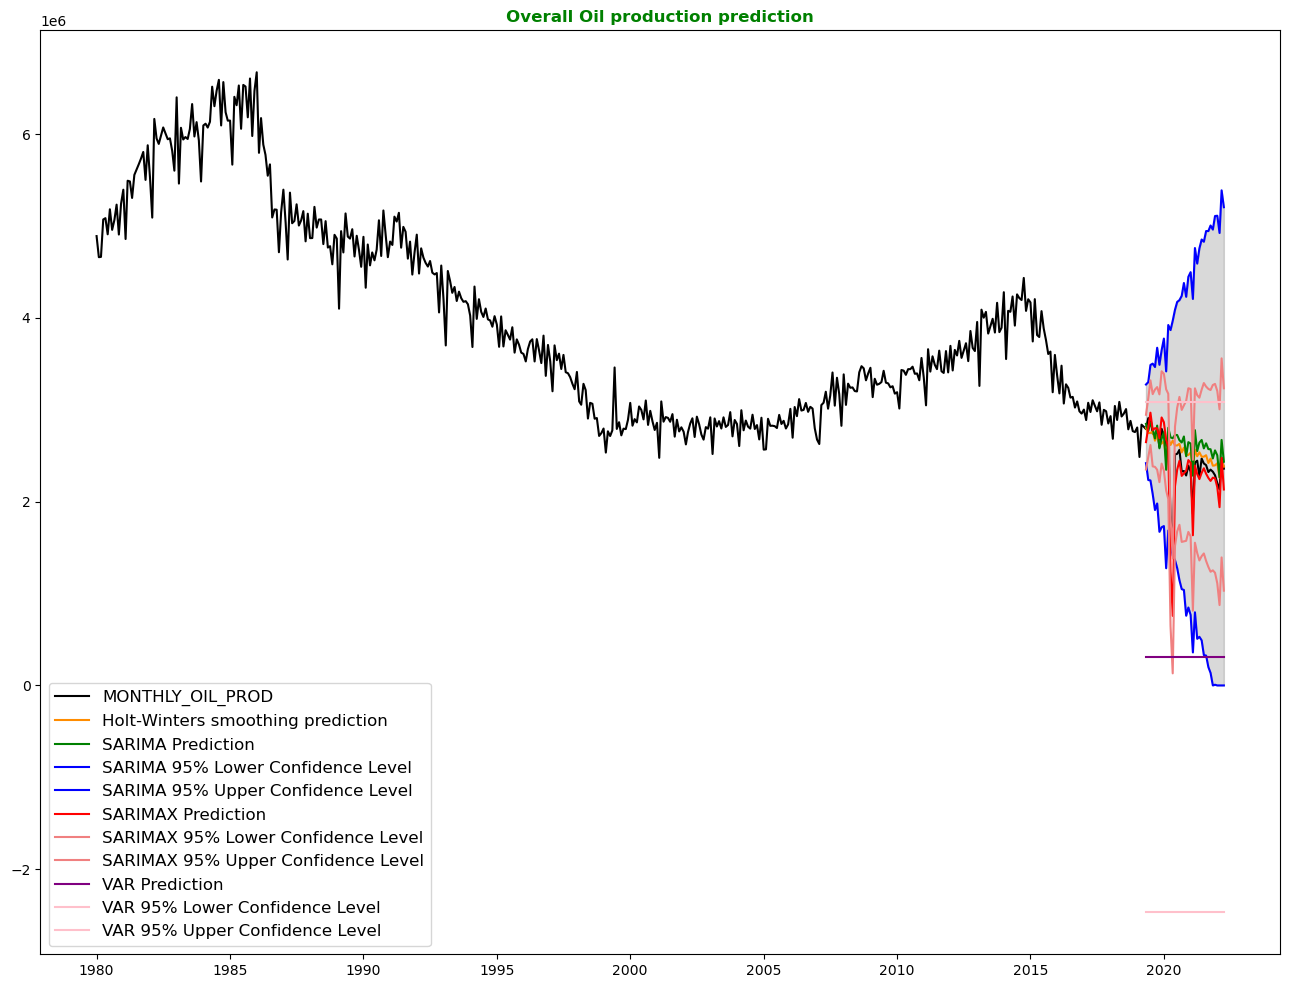

In [50]:
plt.plot(df_oil_prod['MONTHLY_OIL_PROD'], color='black', label='MONTHLY_OIL_PROD')

plt.plot(hw_pred, color='darkorange', label='Holt-Winters smoothing prediction')

plt.plot(pd.Series(fitted), color='green', label='SARIMA Prediction')
plt.plot(lower_conf, color='blue', label='SARIMA 95% Lower Confidence Level')
plt.plot(upper_conf, color='blue', label='SARIMA 95% Upper Confidence Level')

plt.plot(pd.Series(fittedx), color='red', label='SARIMAX Prediction')
plt.plot(lower_confx, color='lightcoral', label='SARIMAX 95% Lower Confidence Level')
plt.plot(upper_confx, color='lightcoral', label='SARIMAX 95% Upper Confidence Level')

plt.plot(pd.Series(var_predictions['MONTHLY_OIL_PROD_predicted']), color='purple', label='VAR Prediction')
plt.plot(lower_conf_var, color='pink', label='VAR 95% Lower Confidence Level')
plt.plot(upper_conf_var, color='pink', label='VAR 95% Upper Confidence Level')


plt.fill_between(lower_conf.index, 
                 lower_conf, 
                 upper_conf, 
                 color='k', alpha=.15)
plt.title('Overall Oil production prediction')
plt.legend(loc='lower left', fontsize=12)
plt.show()

**RMSE values**

In [51]:
gas_prod_mean = np.mean(xvalid['MONTHLY_OIL_PROD'])

rmse_hw = np.sqrt(mean_squared_error(hw_pred, xvalid['MONTHLY_OIL_PROD']))

rmse_sarima = np.sqrt(mean_squared_error(fitted, xvalid['MONTHLY_OIL_PROD']))

rmse_sarimax = np.sqrt(mean_squared_error(fittedx, xvalid['MONTHLY_OIL_PROD']))

rmse_var = np.sqrt(mean_squared_error(var_predictions['MONTHLY_OIL_PROD_predicted'], xvalid['MONTHLY_OIL_PROD']))

print('Mean value of MONTHLY_OIL_PROD is : {}, \nHolt-Winter Root Mean Squared Error is :{}, \
\nSARIMA Root Mean Squared Error is :{}, \nSARIMAX Root Mean Squared Error is :{}, \nVAR Root Mean Squared Error is :{}'
      .format(gas_prod_mean, rmse_hw, rmse_sarima, rmse_sarimax, rmse_var))

Mean value of MONTHLY_OIL_PROD is : 2433243.4677777775, 
Holt-Winter Root Mean Squared Error is :279319.45705214504, 
SARIMA Root Mean Squared Error is :324671.7514541228, 
SARIMAX Root Mean Squared Error is :196753.02238705548, 
VAR Root Mean Squared Error is :2147445.976439452
